# Exploratory Data Analysis for Pet Food Sentiments

This notebook provides the code and visuals to assess possible patterns in the sentiment analysis data for pet food brands.

In [100]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from spacy.matcher import Matcher
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn.objects as so
import warnings
warnings.filterwarnings('ignore')

In [101]:
df = pd.read_csv('SA_data_clean.csv')

In [102]:
#Need to make Tweet_Date a datetime object again
df['Tweet_Date'] = pd.to_datetime(df['Tweet_Date'])

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Tweet_Length   798 non-null    int64              
 1   Tweet_Date     798 non-null    datetime64[ns, UTC]
 2   UserName       798 non-null    object             
 3   Full_Tweets    778 non-null    object             
 4   Tweet_Links    798 non-null    object             
 5   at_word        544 non-null    object             
 6   Mention_Count  798 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 43.8+ KB


In [104]:
df['UserName'].value_counts()

bluebuffalo        200
DiamondPetFood     200
Purina             199
wellnesspetfood    199
Name: UserName, dtype: int64

In [105]:
df.head(3)

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1


In [274]:
%run hist.py
generate_distribution_histogram?

Signature:
generate_distribution_histogram(
    dataframe,
    column_name,
    title,
    x_axis_label,
    y_axis_label,
    orientation='vertical',
    name='hist',
    number_bins=15,
)
Docstring:
This function generates a histogram.
Args:
    dataframe:
    column_name: String. Name of the column whose distribution we want to visualize.
    title: String. Title of the histogram.
    x_axis_label: String. X-axis label.
    y_axis_label: String. Y-axis label.
    orientation: String. Vertical default or horizontal
    number_bin: Int. How many bins? Default is 15
Outputs:
    Histogram containing distribution for specific column column_name.
File:      ~/Desktop/SA_NLP/hist.py
Type:      function

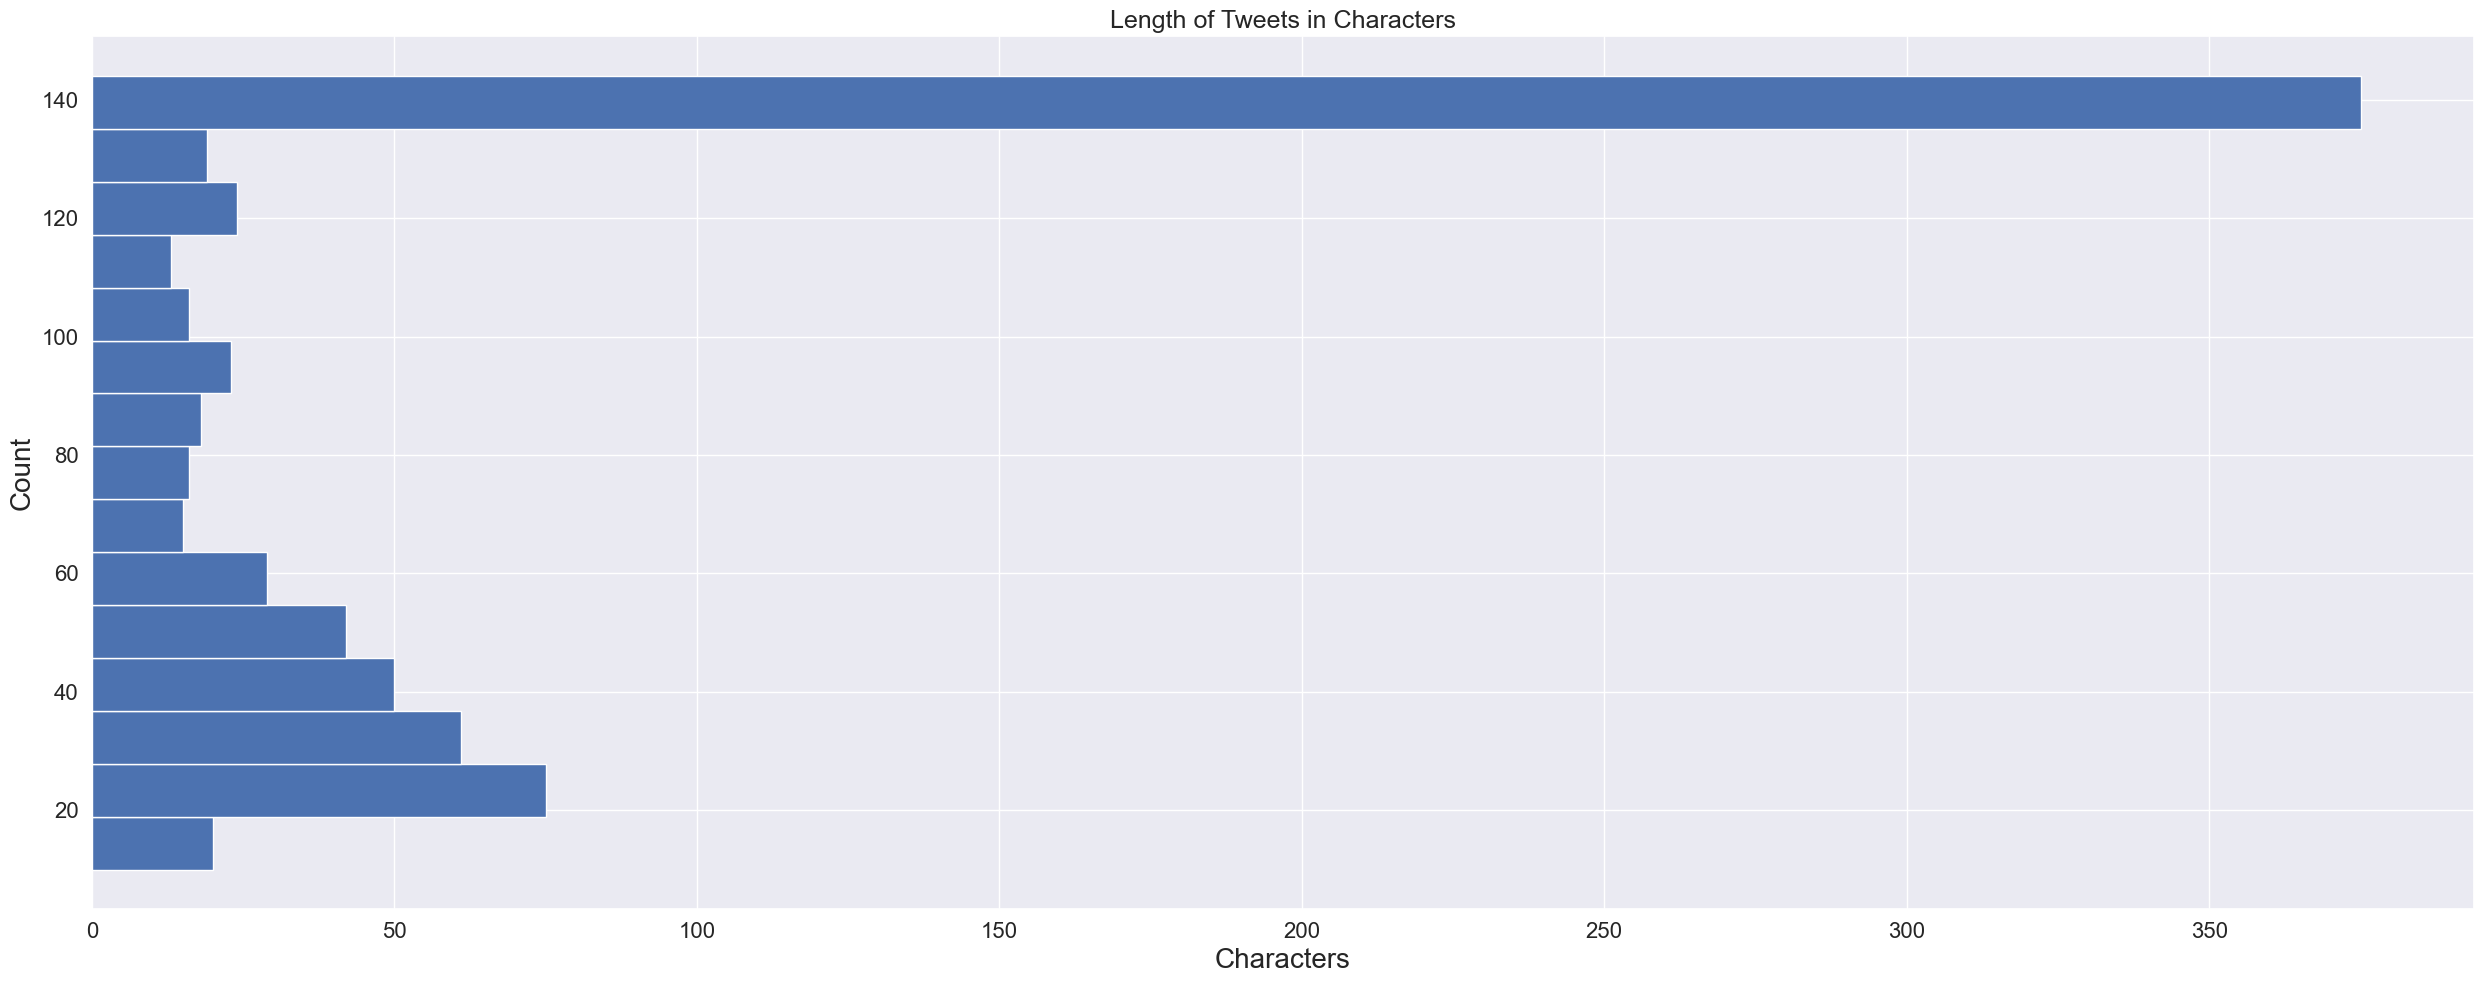

In [275]:
generate_distribution_histogram(df, 'Tweet_Length', 'Length of Tweets in Characters', 'Characters', 'Count', 'horizontal', 'hist tweet length')

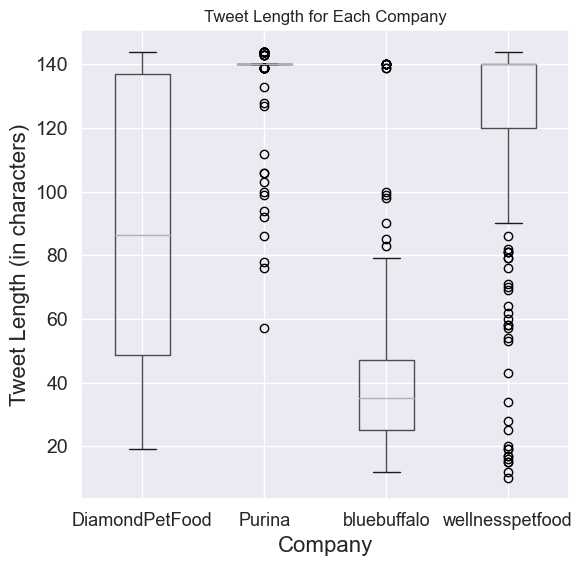

In [279]:
#a boxplot assessment of the tweet length by the four user names
ax = df.boxplot(by='UserName', column='Tweet_Length',
                           figsize=(6, 6))
ax.set_xlabel('Company', fontsize=16)
ax.set_ylabel('Tweet Length (in characters)', fontsize=16)
plt.yticks(rotation = 0, fontsize=14)
plt.xticks(rotation = 0, fontsize=13)
plt.suptitle('')
plt.title('Tweet Length for Each Company')

plt.tight_layout()
plt.savefig('Tweet Length by Company')
plt.show()

The boxplot above is a really interesting distribution. Regardless of sentiment, the companies have taken different approaches to how much they tweet.

In [109]:
##Here the day number of the year out of 365
df['Week'] = df['Tweet_Date'].dt.strftime('%U')

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Tweet_Length   798 non-null    int64              
 1   Tweet_Date     798 non-null    datetime64[ns, UTC]
 2   UserName       798 non-null    object             
 3   Full_Tweets    778 non-null    object             
 4   Tweet_Links    798 non-null    object             
 5   at_word        544 non-null    object             
 6   Mention_Count  798 non-null    int64              
 7   Week           798 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 50.0+ KB


In [111]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Tweet_Length,798.0,96.575188,48.418178,10.0,44.0,124.0,140.0,144.0
Mention_Count,798.0,0.708020,0.512049,0.0,0.0,1.0,1.0,3.0


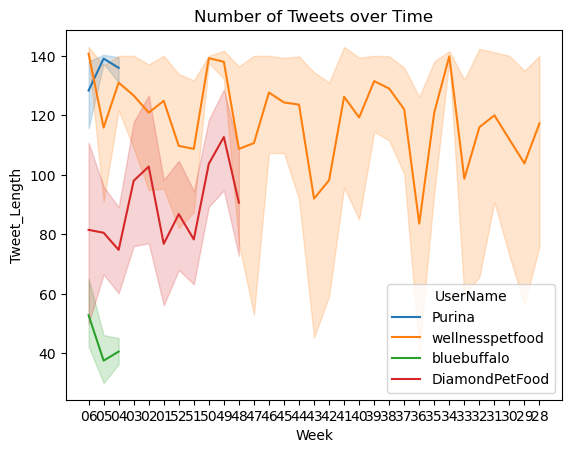

In [112]:
sns.lineplot(data=df, x='Week', y='Tweet_Length', hue='UserName')
plt.title('Number of Tweets over Time')
plt.savefig('Tweet Length by Week')


Clearly the issue for this analysis is that Purina & Blue Buffalo did 200 tweets in a few weeks. <br /> 
It took Diamond less than half a year. <br /> 
Wellness barely did 200 tweets in the year. <br /> 

## ANOVA for Tweet Length

Using statsmodel with help of Practical Statistics for Data Scientists

In [113]:
#Drawing from Practical Stats for DS
observed_variance = df.groupby('UserName').mean().var()[0]
print('Observed means:', df.groupby('UserName').mean().values.ravel())
print('Variance:', observed_variance)


Observed means: [ 86.585        0.49       137.6281407    1.01507538  42.65
   0.99       119.75879397   0.33668342]
Variance: 1743.509492991918


In [114]:
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Tweet_Length'] = np.random.permutation(df['Tweet_Length'].values)
    return df.groupby('UserName').mean().var()[0]
    
print(perm_test(df))

11.044257755065113


In [115]:
perm_variance = [perm_test(df) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Pr(Prob) 0.0


As expected from perusing the boxplot above, there are significant differences in the tweet lengths from these companies.

In [116]:
model = smf.ols('Tweet_Length ~ UserName', data=df).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

             df        sum_sq        mean_sq           F         PR(>F)
UserName    3.0  1.043888e+06  347962.676400  335.076593  1.533300e-140
Residual  794.0  8.245350e+05    1038.457128         NaN            NaN


The ANOVA confirms the level of significance with the F-stastic and the low p value.

## Part of Speech Pattern Assessment

### Adjectives

Let's use spaCy's Matcher to find out about adjectives, nouns, and verbs in these tweets.
Both the count (possibly proportion) of these and the most frequent of each category might be telling.

So what do I want out of this? A column with number of adjectives, one with number of verbs, and another with number of nouns? That can be in the dataframe for the ML analysis.

For comparison, I may need a different df for each company: one with UserName, and then top 20 Adj, Noun, Verb. If plotting them in a four square bar plot, it may be top 10. No stats here. Just a sense of what they are using. Maybe even top 5 to be visible; Draw on previous plots here.

In [117]:
### Working with their English pipeline (medium)
nlp = spacy.load("en_core_web_md")
nlp

In [118]:
# function to vectorize each tweet itteratively like SAR = nlp(text); 
# May need to combine these two into one so that it runs through
# As I need to create a matcher of the total vocab...Might concatenate as a text file
# and run the matcher on that outside the function

In [119]:
%run grouper.py

In [120]:
full_text = df['Full_Tweets'].apply(grouper)


In [121]:
print(full_text[:10])

0     thank you for reaching out  we re sorry that ...
1     thank you for reaching out  we re sorry that ...
2     thank you for reaching out to us  when you ha...
3     thanks for reaching out about alpo come   get...
4     we can t keep our tails from wagging in antic...
5     thanks for reaching out  please know that we ...
6     we ve got our paws crossed that brittany and ...
7     we are sorry to see that you had this experie...
8     thanks for reaching out  tammy  we are so sor...
9     we re so happy to hear that pappy is enjoying...
Name: Full_Tweets, dtype: object


In [122]:
#making the series digestible for the nlp vectorizer
full_text_str = full_text.to_string()

In [123]:
#Vectorizing
nlp_text = nlp(full_text_str)

In [124]:
#Running the matcher on the vectorized vocab string to test it out
matcher = Matcher(nlp_text.vocab)

In [125]:
### Working with Matcher to find POS
pattern = [{"POS": "ADJ"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(nlp_text)

In [126]:
#Testing it out:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = nlp_text[start:end]
    print(matched_span.text)

sorry
sorry
antic
sorry
experie
happy
appreciative
entire
sorry
sorry
sorry
sorry
sorry
sorry
hi
hi
hi
hi
hi
domestic
hi
hi
hi
domestic
limited
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
thrilled
thrivin
domestic
domestic
hi
hi
hi
great
hi
hi
hi
hi
hi
great
happy
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
amazing
furry
sorry
hard
happy
much
similar
sorry
sorry
similar
similar
similar
sorry
pleased
sorry
pet
sorry
similar
similar
sorry
sorry
sorry
disappointing
gorgeous
sorr
amazing
sorry
sorry
sorry
sorry
disappointing
sorry
sorry
sorry
unable
good
true
true
petdentalhealthmonth
pet
dental
pet
dental
top
big
best
petdentalhealthmonth
complete
pet
quick
fresh
happy
open
sorry
ill
best
dental
digestive
first
new
new
tasty
new
yummy
tiny
sorry
sorry
wonderful
perfect
chewww
glad
hi
full
old
wonderful
little
hi
recent
hi
recent
hi
recent
hi
recent
sure
lovin
happy
hi
worthy
good
nationalcookieday
yummy
own
brisk
hi
lazy
cozy
favorite
old
crucial
straight
cute
most
black
fri

In [127]:
%run top_n_ADJs
top_n_ADJs?

Signature: top_n_ADJs(text, n, word_count_dict_input=None)
Docstring:
Purpose: Make a dictionary of most frequent number of Adjs, tokenizes and lemmatizes first
                    keys are POSes in list_of_pos, values are dictionaries with word counts
    Pandas as pd, spacy, spacy.load("en_core_web_md")
    Args: 
            text: as a spacy vectorized object
            n: number of top Adjs user wants as int
            word_count_dict_input: (Optional dictionary of the proper input)
    Returns: dictionary: frequent_word_count_dict
File:      ~/Desktop/SA_NLP/top_n_ADJs.py
Type:      function

In [128]:
frequent_word_count_dict = top_n_ADJs(nlp_text, 5)

In [129]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
adjs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
adjs_df = adjs_df.sort_values(by=['ADJ'], ascending=False)
adjs_df.reset_index(inplace=True)
adjs_df.rename(columns={'ADJ':'count'}, inplace=True)
adjs_df.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df.head()

,ADJ,count
0,hi,63
1,sorry,37
2,good,19
3,happy,14
4,new,10


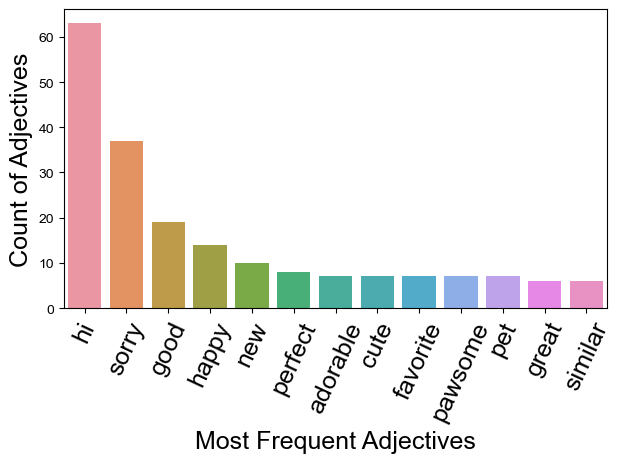

In [130]:
sns.barplot(x='ADJ', y='count', data=adjs_df.query('count > 5').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Adjectives', fontsize=18)
plt.ylabel('Count of Adjectives', fontsize=18)
plt.xticks(rotation = 65, fontsize=18)
plt.tight_layout()
plt.savefig('Count for Frequent Adjectives')
plt.show()

So we can see here that a big function for at least some of these pet food companies on Twitter is the speech act of **apologizing**. <br/> Some of these adjectives are very basic in what they do like _happy_ & _good_. One is a creative blend: _pawsome_. <br/> 
Next let's look at the top adjectives for each company.

In [131]:
#Making a separate text corpus for each company
full_text_bluebuffalo = df[df.UserName == 'bluebuffalo'].Full_Tweets.apply(grouper)
full_text_DiamondPetFood = df[df.UserName == 'DiamondPetFood'].Full_Tweets.apply(grouper)
full_text_Purina = df[df.UserName == 'Purina'].Full_Tweets.apply(grouper)
full_text_wellnesspetfood = df[df.UserName == 'wellnesspetfood'].Full_Tweets.apply(grouper)


In [132]:
full_text_wellnesspetfood[:5]

199    we have got the key to your pups heart with  o...
200    it is takeover time  our friends dexter   dara...
201    feeling good from the inside out with wellness...
202    have a puppy that needs training  we re here t...
203    can hardly wait to get into this tuna   shrimp...
Name: Full_Tweets, dtype: object

In [133]:
# Vectorize each of these after converting to just strings
#making the series digestible for the nlp vectorizer
full_text_str_bluebuffalo = full_text_bluebuffalo.to_string()
full_text_str_DiamondPetFood = full_text_DiamondPetFood.to_string()
full_text_str_Purina = full_text_Purina.to_string()
full_text_str_wellnesspetfood = full_text_wellnesspetfood.to_string()

In [134]:
#Vectorizing
nlp_bluebuffalo = nlp(full_text_str_bluebuffalo)
nlp_DiamondPetFood = nlp(full_text_str_DiamondPetFood)
nlp_Purina = nlp(full_text_str_Purina)
nlp_wellnesspetfood = nlp(full_text_str_wellnesspetfood)

In [135]:
dict_bluebuffalo = top_n_ADJs(nlp_bluebuffalo, 3)
dict_DiamondPetFood = top_n_ADJs(nlp_DiamondPetFood, 3)
dict_Purina = top_n_ADJs(nlp_Purina, 3)
dict_wellnesspetfood = top_n_ADJs(nlp_wellnesspetfood, 3)

In [136]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
adjs_df_bluebuffalo = pd.DataFrame.from_dict(dict_bluebuffalo)
adjs_df_bluebuffalo = adjs_df_bluebuffalo.sort_values(by=['ADJ'], ascending=False)
adjs_df_bluebuffalo.reset_index(inplace=True)
adjs_df_bluebuffalo.rename(columns={'ADJ':'count'}, inplace=True)
adjs_df_bluebuffalo.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df_bluebuffalo.columns

Index(['ADJ', 'count'], dtype='object')

In [137]:
adjs_df_bluebuffalo.head()

,ADJ,count
0,good,6
1,aware,5
2,nice,4


In [138]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
adjs_df_Purina = pd.DataFrame.from_dict(dict_Purina)
adjs_df_Purina = adjs_df_Purina.sort_values(by=['ADJ'], ascending=False)
adjs_df_Purina.reset_index(inplace=True)
adjs_df_Purina.rename(columns={'ADJ':'count'}, inplace=True)
adjs_df_Purina.rename(columns={'index':'ADJ'}, inplace=True)
#adjs_df_Purina.columns
adjs_df_Purina.head(10)

,ADJ,count
0,hi,50
1,sorry,25
2,similar,6
3,domestic,4


In [139]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
adjs_df_DiamondPetFood = pd.DataFrame.from_dict(dict_DiamondPetFood)
adjs_df_DiamondPetFood = adjs_df_DiamondPetFood.sort_values(by=['ADJ'], ascending=False)
adjs_df_DiamondPetFood.reset_index(inplace=True)
adjs_df_DiamondPetFood.rename(columns={'ADJ':'count'}, inplace=True)
adjs_df_DiamondPetFood.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df_DiamondPetFood.columns
adjs_df_DiamondPetFood.head()

,ADJ,count
0,adorable,7
1,pawsome,7
2,happy,6
3,new,6
4,favorite,4


In [140]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
adjs_df_wellnesspetfood = pd.DataFrame.from_dict(dict_wellnesspetfood)
adjs_df_wellnesspetfood = adjs_df_wellnesspetfood.sort_values(by=['ADJ'], ascending=False)
adjs_df_wellnesspetfood.reset_index(inplace=True)
adjs_df_wellnesspetfood.rename(columns={'ADJ':'count'}, inplace=True)
adjs_df_wellnesspetfood.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df_wellnesspetfood.columns
adjs_df_wellnesspetfood.head()

,ADJ,count
0,good,10
1,sorry,10
2,hi,9
3,perfect,5
4,dental,4


In [141]:
adjs_df_wellnesspetfood['UserName'] = 'wellnesspetfood'
adjs_df_Purina['UserName'] = 'Purina'
adjs_df_DiamondPetFood['UserName'] = 'DiamondPetFood'
adjs_df_bluebuffalo['UserName'] = 'bluebuffalo'


In [142]:
frames = [adjs_df_Purina, adjs_df_bluebuffalo, adjs_df_DiamondPetFood, adjs_df_wellnesspetfood]
df_adjs_count = pd.concat(frames)

In [143]:
df_adjs_count.UserName.value_counts()

wellnesspetfood    8
DiamondPetFood     5
Purina             4
bluebuffalo        3
Name: UserName, dtype: int64

In [144]:
df_adjs_count.to_csv('Adjs_count.csv', index=False)

In [145]:
df_adjs_count = pd.read_csv('Adjs_count.csv')

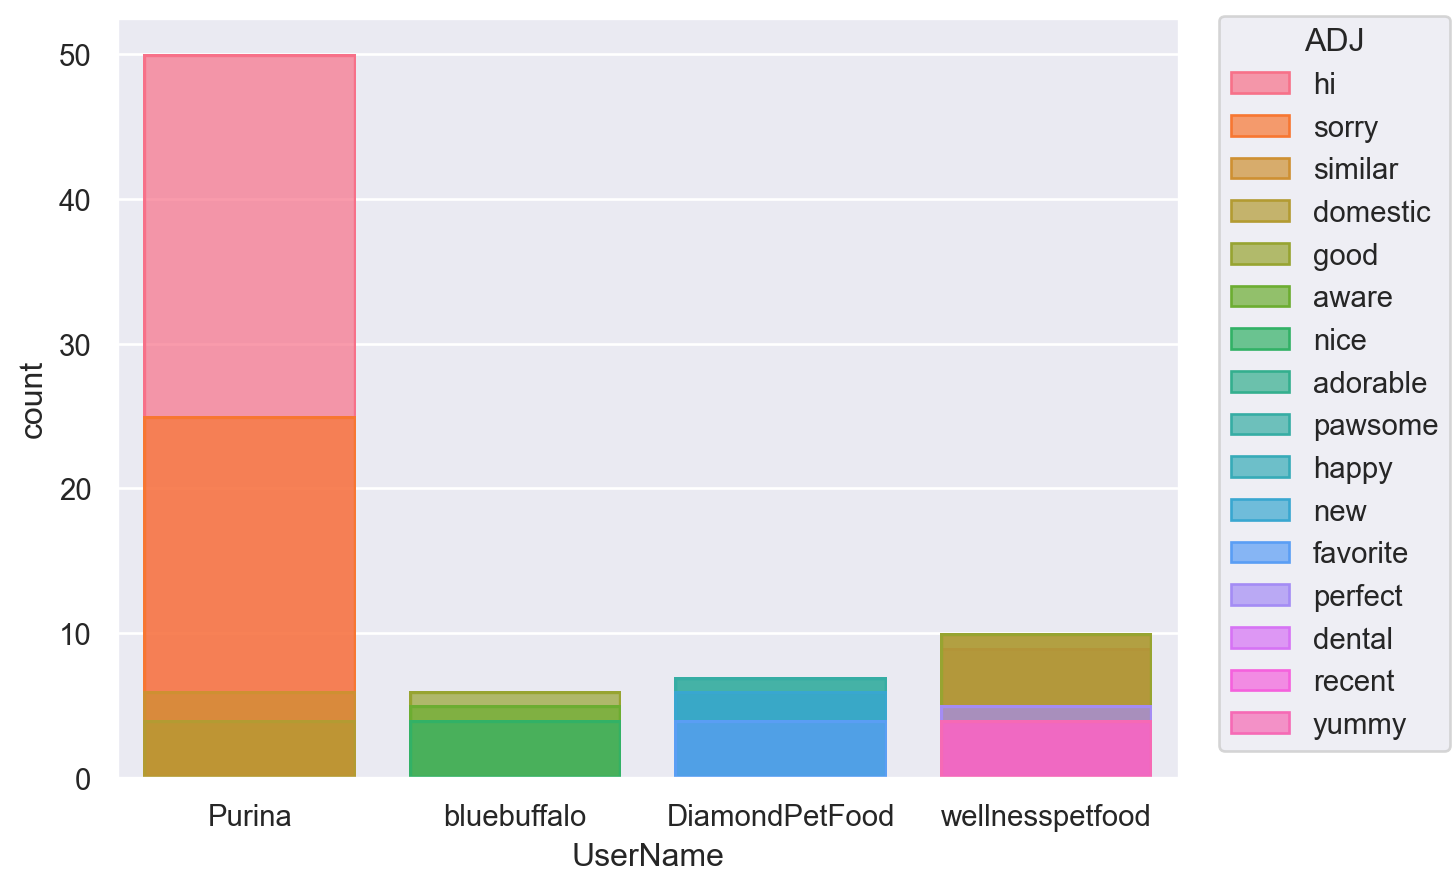

In [146]:
(
    so.Plot(df_adjs_count, x="UserName", y="count", color="ADJ")
    .add(so.Bar(), so.Agg())
    
)


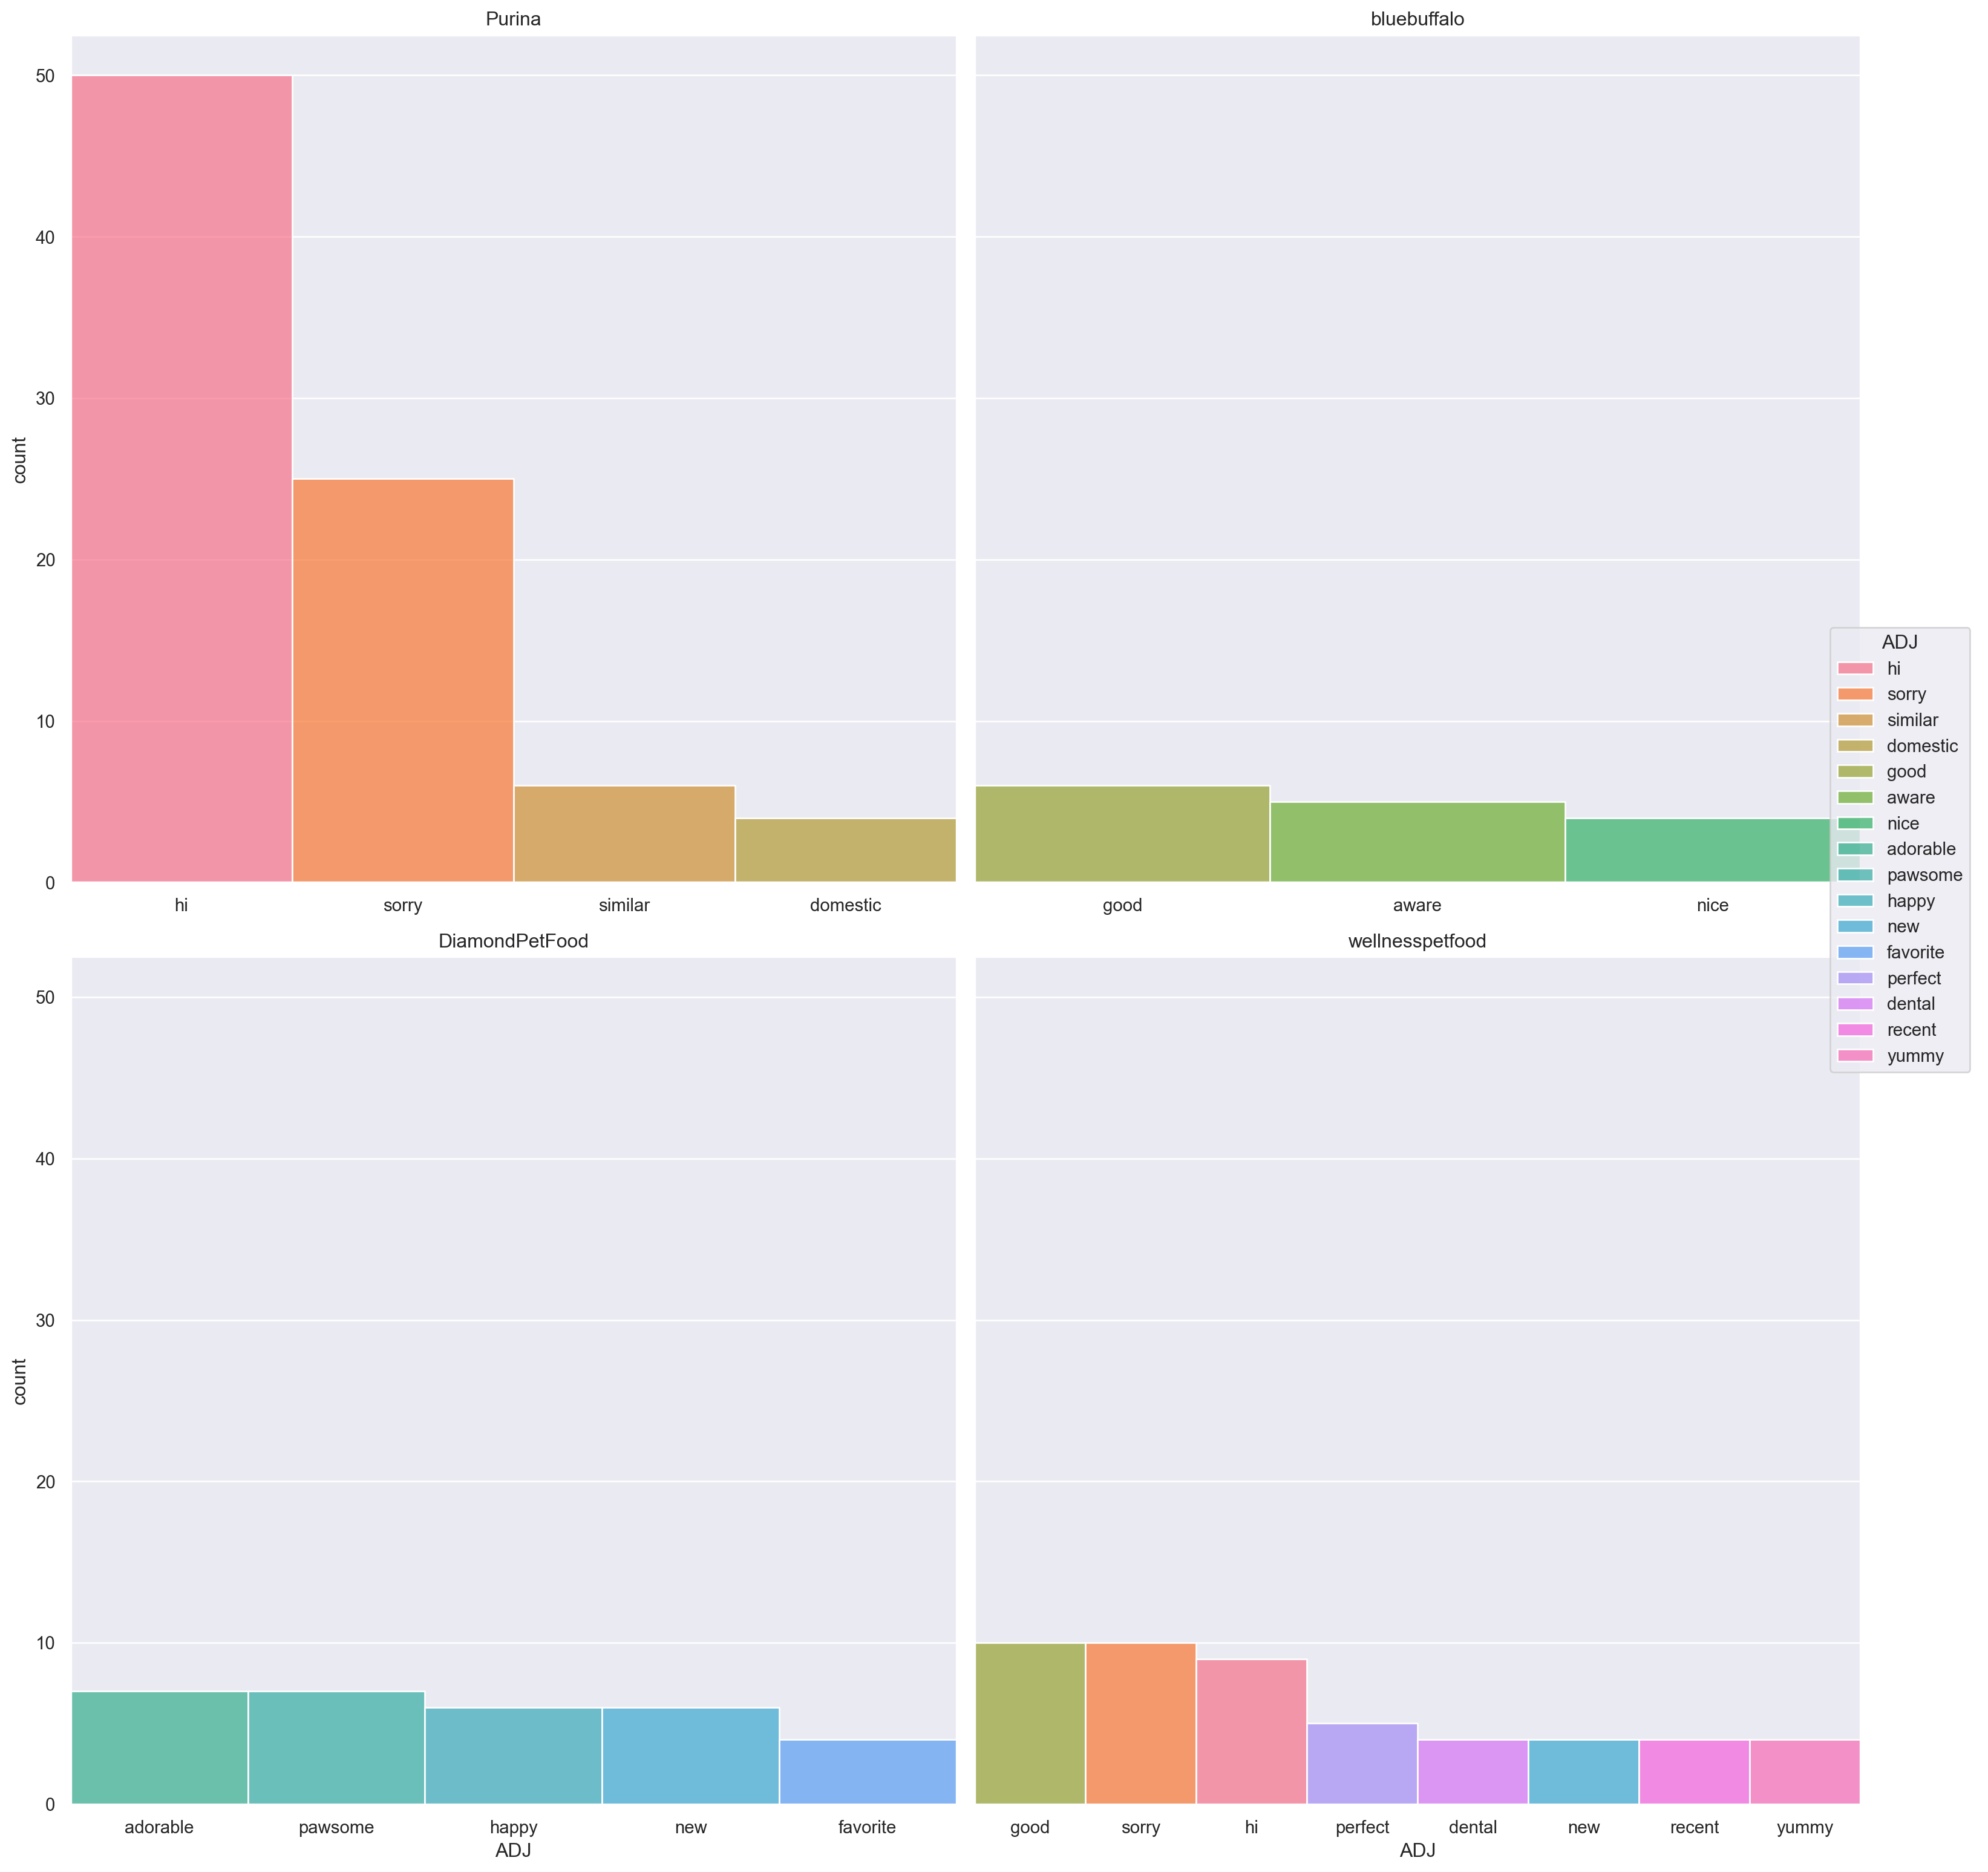

In [147]:
(
    so.Plot(df_adjs_count, x="ADJ", y="count", color="ADJ")
    .facet(col="UserName", wrap=2)
    .add(so.Bars()).save('/Users/kirk/Desktop/SA_NLP/so_adjs_company.png').share(x=False, y=True).layout(size=(16, 16), engine="constrained")
)
# Because of such different adjective uses amongst the companies

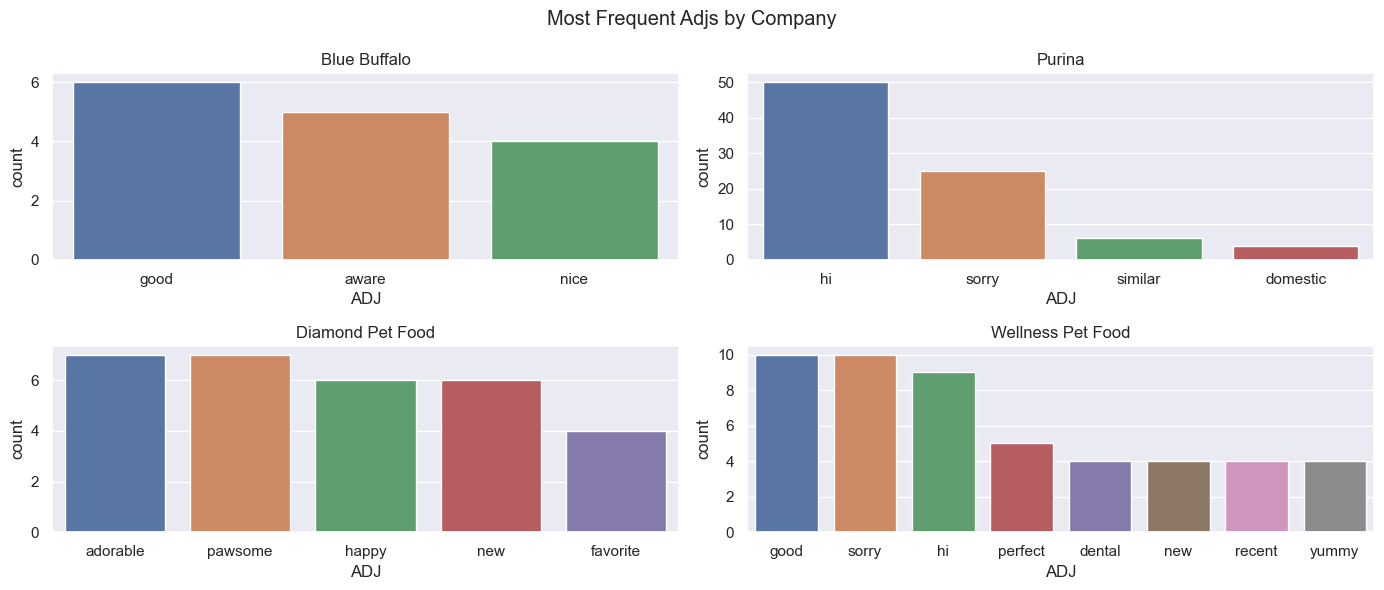

In [148]:
##trying again from matplotlib setup
figure, axes = plt.subplots(2, 2, sharex=False, figsize=(14,6))
figure.suptitle('Most Frequent Adjs by Company')
sns.barplot(ax=axes[0, 0], x='ADJ', y='count', data=df_adjs_count[df_adjs_count.UserName == 'bluebuffalo']).set(title='Blue Buffalo')
sns.barplot(ax=axes[0, 1], x='ADJ', y='count', data=df_adjs_count[df_adjs_count.UserName == 'Purina']).set(title='Purina')
sns.barplot(ax=axes[1, 0], x='ADJ', y='count', data=df_adjs_count[df_adjs_count.UserName == 'DiamondPetFood']).set(title='Diamond Pet Food')
sns.barplot(ax=axes[1, 1], x='ADJ', y='count', data=df_adjs_count[df_adjs_count.UserName == 'wellnesspetfood']).set(title='Wellness Pet Food')
margin_titles=True
plt.tight_layout()
plt.savefig('By Company Count for Frequent Adjectives')

Now that we have a sense of adjective usage amongst the four companies, let's take a look at the number of adjectives per tweet and capture that as a feature for the ML algorythm.

In [149]:
### Working with their English pipeline (medium)
nlp = spacy.load("en_core_web_md")
nlp

In [150]:
#With a bit of help from Datacamp
# Returns number of proper nouns
def count_ADJs(text, model=nlp):
  	# Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper ADJs
    return pos.count('ADJ')

In [151]:
#testing this out
test_text = "Thirsty dirty old yellow big chickens sitting on their nests"
count_ADJs(test_text)

5

In [152]:
# Despite Full_Tweets being an object in both cases, It still reuired conversion to string (still object!) to open to nlp vectorizing
df['Full_Tweets']= df['Full_Tweets'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Tweet_Length   798 non-null    int64              
 1   Tweet_Date     798 non-null    datetime64[ns, UTC]
 2   UserName       798 non-null    object             
 3   Full_Tweets    798 non-null    object             
 4   Tweet_Links    798 non-null    object             
 5   at_word        544 non-null    object             
 6   Mention_Count  798 non-null    int64              
 7   Week           798 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 50.0+ KB


In [153]:
df['Count_ADJs'] = df['Full_Tweets'].apply(lambda x: count_ADJs(x))

In [154]:
df.tail()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs
793,96,2022-11-30 19:49:06+00:00,DiamondPetFood,harness on outdoor adventure ready katad...,https://t.co/twWB3oWDFH,NaN,0,48,2
794,113,2022-11-30 19:47:06+00:00,DiamondPetFood,finley has his paws crossed because he is a ge...,https://t.co/baHt2b3yxD,NaN,0,48,1
795,96,2022-11-29 19:48:02+00:00,DiamondPetFood,sorry i have plans the plans petting my...,httpNone,NaN,0,48,1
796,95,2022-11-29 19:47:06+00:00,DiamondPetFood,hermes loves dates at the dog park anybody el...,https://t.co/DIAAi3VbUX,NaN,0,48,0
797,80,2022-11-28 21:45:06+00:00,DiamondPetFood,where did all of these cardboard boxes come f...,https://t.co/Kr8AlRG8GD,NaN,0,48,0


In [155]:
df.Count_ADJs.value_counts()

0    348
1    265
2    121
3     48
4     14
6      1
5      1
Name: Count_ADJs, dtype: int64

## Nouns in Tweets

In [156]:
%run top_n_Nouns.py

In [157]:
frequent_word_count_dict = top_n_Nouns(nlp_text, 5)

In [158]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
nouns_df = pd.DataFrame.from_dict(frequent_word_count_dict)
nouns_df = nouns_df.sort_values(by=['NOUN'], ascending=False)
nouns_df.reset_index(inplace=True)
nouns_df.rename(columns={'NOUN':'count'}, inplace=True)
nouns_df.rename(columns={'index':'NOUN'}, inplace=True)
nouns_df.head()

,NOUN,count
0,dog,58
1,tag,50
2,thank,31
3,company,28
4,cat,25


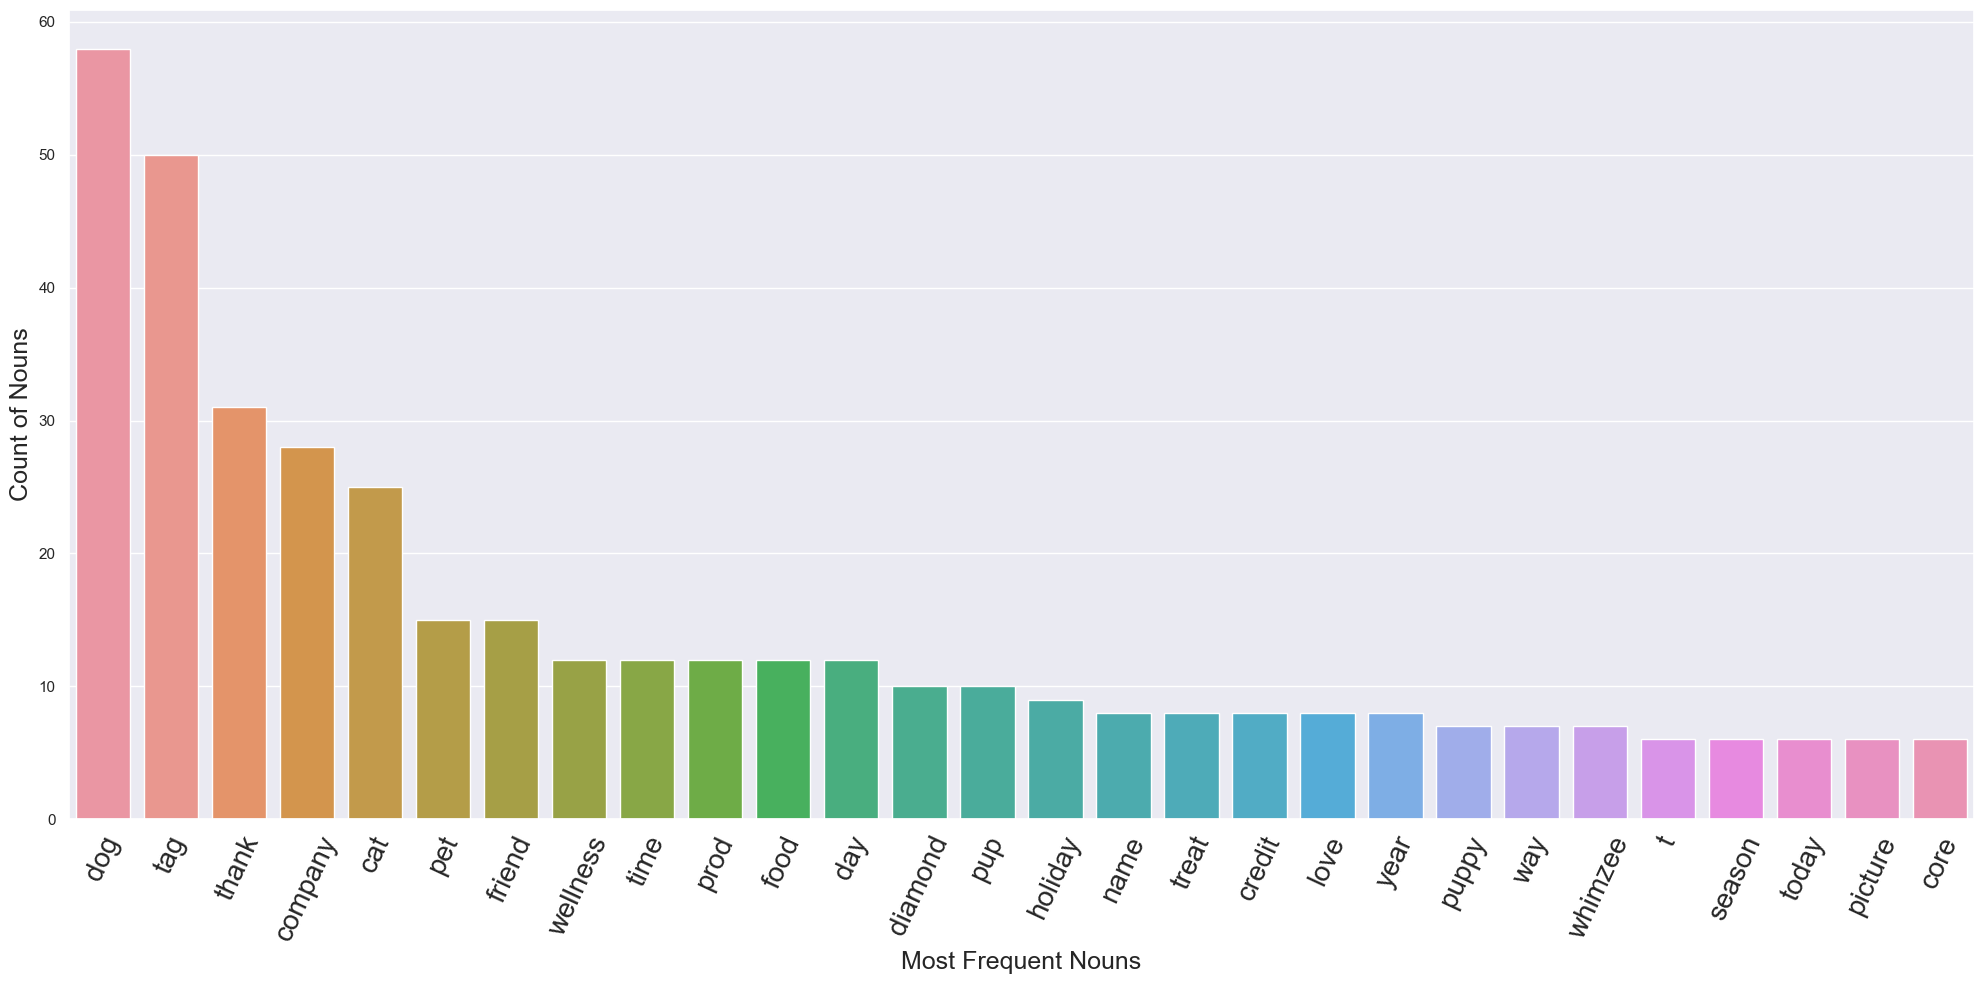

In [159]:
sns.barplot(x='NOUN', y='count', data=nouns_df.query('count > 5').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(25,10)})
plt.xlabel('Most Frequent Nouns', fontsize=18)
plt.ylabel('Count of Nouns', fontsize=18)
plt.xticks(rotation = 65, fontsize=20)
plt.tight_layout()
plt.savefig('Count for Frequent Nouns')
plt.show()

In [160]:
dict_bluebuffalo = top_n_Nouns(nlp_bluebuffalo, 3)
dict_DiamondPetFood = top_n_Nouns(nlp_DiamondPetFood, 3)
dict_Purina = top_n_Nouns(nlp_Purina, 3)
dict_wellnesspetfood = top_n_Nouns(nlp_wellnesspetfood, 3)

In [161]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Nouns_df_bluebuffalo = pd.DataFrame.from_dict(dict_bluebuffalo)
Nouns_df_bluebuffalo = Nouns_df_bluebuffalo.sort_values(by=['NOUN'], ascending=False)
Nouns_df_bluebuffalo.reset_index(inplace=True)
Nouns_df_bluebuffalo.rename(columns={'NOUN':'count'}, inplace=True)
Nouns_df_bluebuffalo.rename(columns={'index':'NOUN'}, inplace=True)
Nouns_df_bluebuffalo.columns

Index(['NOUN', 'count'], dtype='object')

In [162]:
Nouns_df_bluebuffalo.head()

,NOUN,count
0,friend,10
1,cat,5
2,oughe,4
3,time,4


In [163]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Nouns_df_Purina = pd.DataFrame.from_dict(dict_Purina)
Nouns_df_Purina = Nouns_df_Purina.sort_values(by=['NOUN'], ascending=False)
Nouns_df_Purina.reset_index(inplace=True)
Nouns_df_Purina.rename(columns={'NOUN':'count'}, inplace=True)
Nouns_df_Purina.rename(columns={'index':'NOUN'}, inplace=True)
#Nouns_df_Purina.columns
Nouns_df_Purina.head(10)

,NOUN,count
0,tag,50
1,dog,38
2,company,28
3,cat,12
4,prod,12
5,thank,12
6,name,6
7,i,4


In [164]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Nouns_df_DiamondPetFood = pd.DataFrame.from_dict(dict_DiamondPetFood)
Nouns_df_DiamondPetFood = Nouns_df_DiamondPetFood.sort_values(by=['NOUN'], ascending=False)
Nouns_df_DiamondPetFood.reset_index(inplace=True)
Nouns_df_DiamondPetFood.rename(columns={'NOUN':'count'}, inplace=True)
Nouns_df_DiamondPetFood.rename(columns={'index':'NOUN'}, inplace=True)
#Nouns_df_DiamondPetFood.columns
Nouns_df_DiamondPetFood.head()

,NOUN,count
0,pet,12
1,thank,11
2,diamond,10
3,credit,8
4,dog,7


In [165]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Nouns_df_wellnesspetfood = pd.DataFrame.from_dict(dict_wellnesspetfood)
Nouns_df_wellnesspetfood = Nouns_df_wellnesspetfood.sort_values(by=['NOUN'], ascending=False)
Nouns_df_wellnesspetfood.reset_index(inplace=True)
Nouns_df_wellnesspetfood.rename(columns={'NOUN':'count'}, inplace=True)
Nouns_df_wellnesspetfood.rename(columns={'index':'NOUN'}, inplace=True)
Nouns_df_wellnesspetfood.columns
Nouns_df_wellnesspetfood.head()

,NOUN,count
0,dog,12
1,wellness,12
2,day,10
3,treat,8
4,whimzee,7


In [166]:
Nouns_df_wellnesspetfood['UserName'] = 'wellnesspetfood'
Nouns_df_Purina['UserName'] = 'Purina'
Nouns_df_DiamondPetFood['UserName'] = 'DiamondPetFood'
Nouns_df_bluebuffalo['UserName'] = 'bluebuffalo'


In [167]:
Nouns_df_bluebuffalo.head()

,NOUN,count,UserName
0,friend,10,bluebuffalo
1,cat,5,bluebuffalo
2,oughe,4,bluebuffalo
3,time,4,bluebuffalo


In [168]:
frames = [Nouns_df_Purina, Nouns_df_bluebuffalo, Nouns_df_DiamondPetFood, Nouns_df_wellnesspetfood]
df_Nouns_count = pd.concat(frames)

In [169]:
df_Nouns_count.UserName.value_counts()

wellnesspetfood    21
DiamondPetFood     10
Purina              8
bluebuffalo         4
Name: UserName, dtype: int64

In [170]:
df_Nouns_count.to_csv('Nouns_count.csv', index=False)

In [171]:
# Had to restart Kernel
df_Nouns_count = pd.read_csv('Nouns_count.csv')

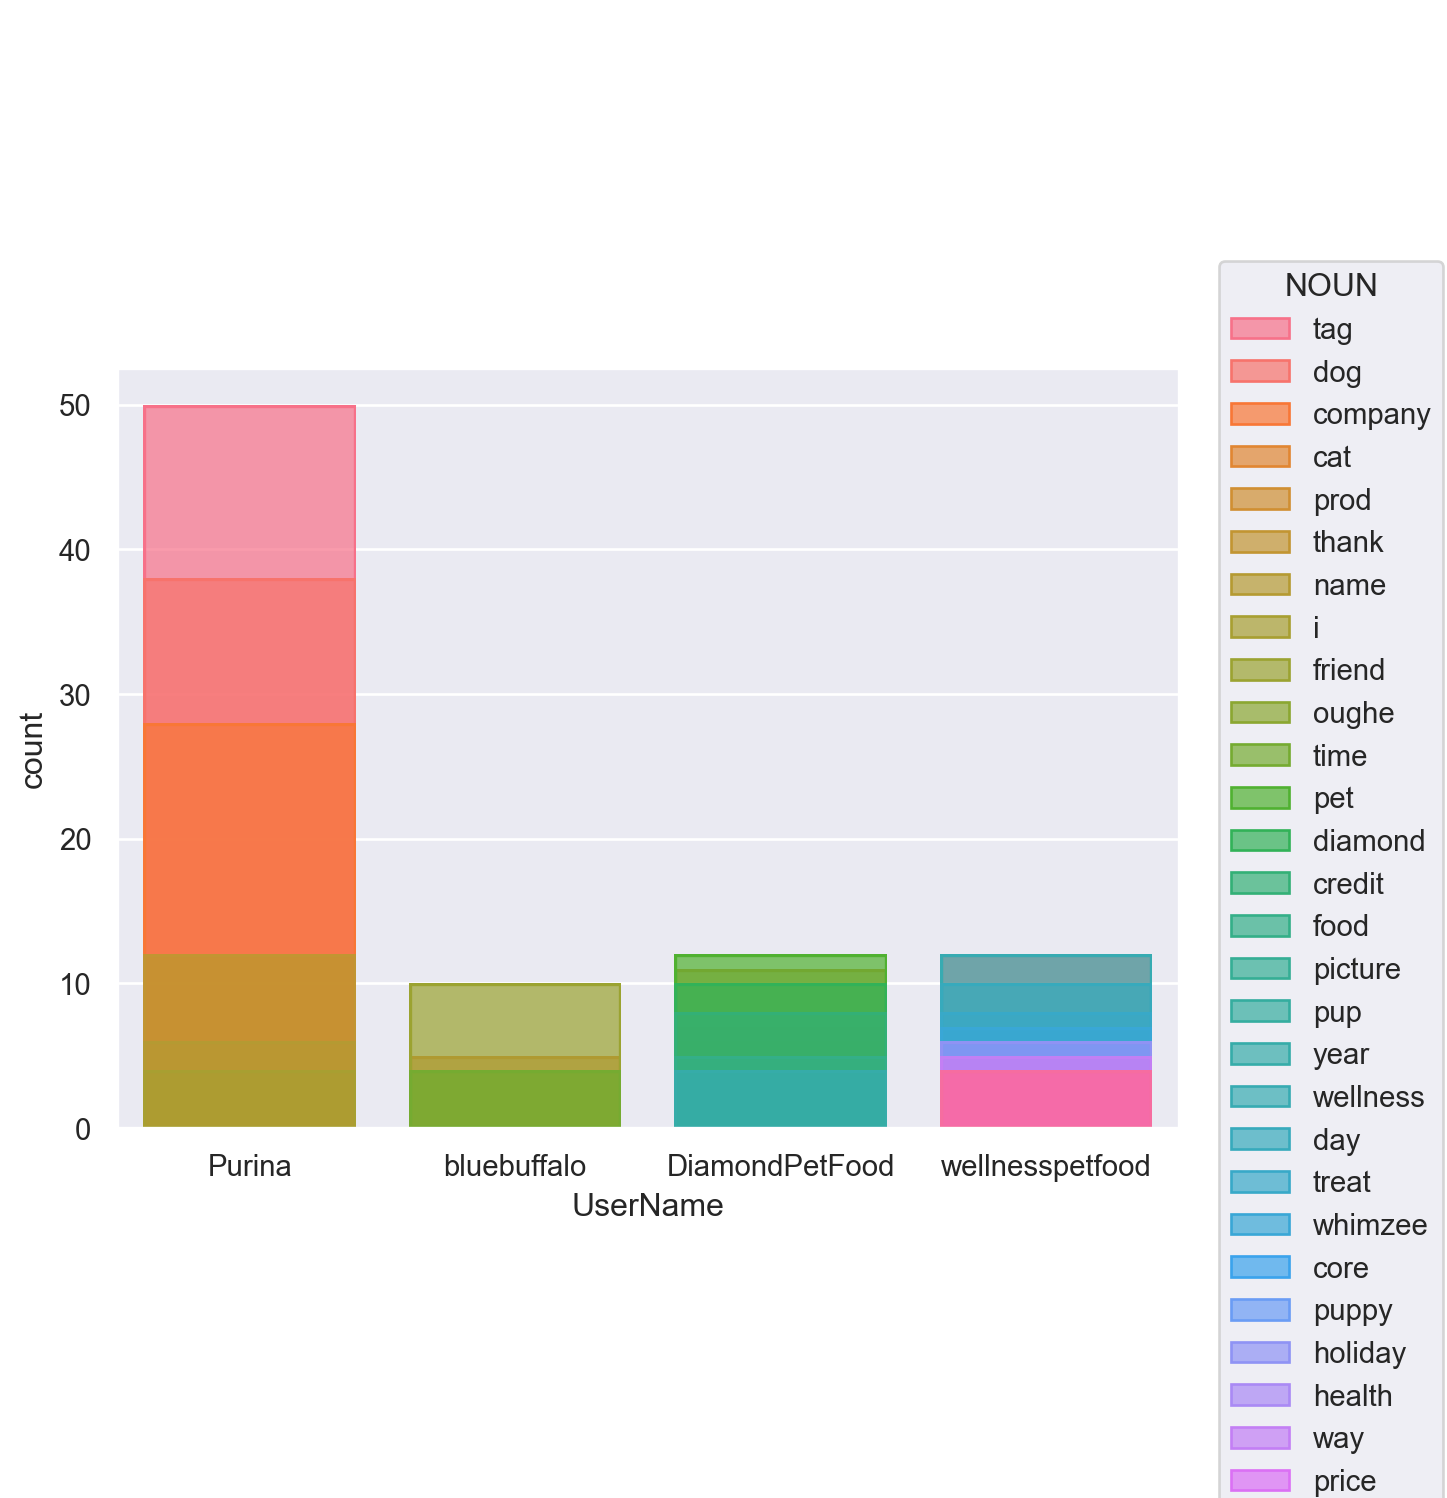

In [172]:
(
    so.Plot(df_Nouns_count, x="UserName", y="count", color="NOUN")
    .add(so.Bar(), so.Agg())
    
)


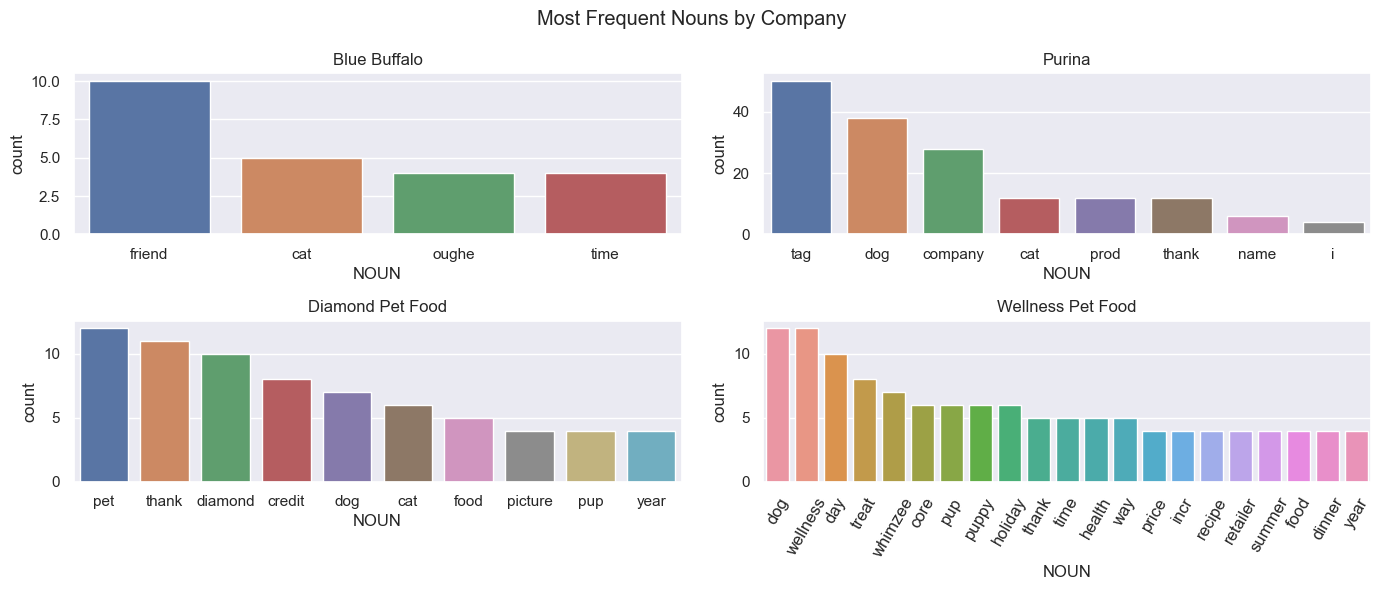

In [173]:
##trying again from matplotlib setup
figure, axes = plt.subplots(2, 2, sharex=False, figsize=(14,6))
figure.suptitle('Most Frequent Nouns by Company')
sns.barplot(ax=axes[0, 0], x='NOUN', y='count', data=df_Nouns_count[df_Nouns_count.UserName == 'bluebuffalo']).set(title='Blue Buffalo')
sns.barplot(ax=axes[0, 1], x='NOUN', y='count', data=df_Nouns_count[df_Nouns_count.UserName == 'Purina']).set(title='Purina')
sns.barplot(ax=axes[1, 0], x='NOUN', y='count', data=df_Nouns_count[df_Nouns_count.UserName == 'DiamondPetFood']).set(title='Diamond Pet Food')
sns.barplot(ax=axes[1, 1], x='NOUN', y='count', data=df_Nouns_count[df_Nouns_count.UserName == 'wellnesspetfood']).set(title='Wellness Pet Food')
margin_titles=True
plt.xticks(rotation = 60, fontsize=12)
plt.tight_layout()
plt.savefig('By Company Count for Frequent Nouns')

We have a sense of the nouns in each comany's set of Tweets. Purina and Wellness are the most self referential, with Diamond a close third.

In [174]:
#With a bit of help from Datacamp
# Returns number of proper nouns
def count_Nouns(text, model=nlp):
  	# Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper ADJs
    return pos.count('NOUN')

In [175]:
#testing this out
test_text = "Thirsty dirty old yellow big chickens sitting on their nests"
count_Nouns(test_text)

2

In [176]:
df['Count_NOUNS'] = df['Full_Tweets'].apply(lambda x: count_Nouns(x))

In [177]:
df.tail()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS
793,96,2022-11-30 19:49:06+00:00,DiamondPetFood,harness on outdoor adventure ready katad...,https://t.co/twWB3oWDFH,NaN,0,48,2,3
794,113,2022-11-30 19:47:06+00:00,DiamondPetFood,finley has his paws crossed because he is a ge...,https://t.co/baHt2b3yxD,NaN,0,48,1,3
795,96,2022-11-29 19:48:02+00:00,DiamondPetFood,sorry i have plans the plans petting my...,httpNone,NaN,0,48,1,5
796,95,2022-11-29 19:47:06+00:00,DiamondPetFood,hermes loves dates at the dog park anybody el...,https://t.co/DIAAi3VbUX,NaN,0,48,0,3
797,80,2022-11-28 21:45:06+00:00,DiamondPetFood,where did all of these cardboard boxes come f...,https://t.co/Kr8AlRG8GD,NaN,0,48,0,2


## Verbs

In [178]:
%run top_n_Verbs.py

In [179]:
frequent_word_count_dict = top_n_Verbs(nlp_text, 5)

In [180]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
verbs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
verbs_df = verbs_df.sort_values(by=['VERB'], ascending=False)
verbs_df.reset_index(inplace=True)
verbs_df.rename(columns={'VERB':'count'}, inplace=True)
verbs_df.rename(columns={'index':'VERB'}, inplace=True)
verbs_df.head()

,VERB,count
0,know,68
1,make,55
2,use,51
3,thank,34
4,have,31


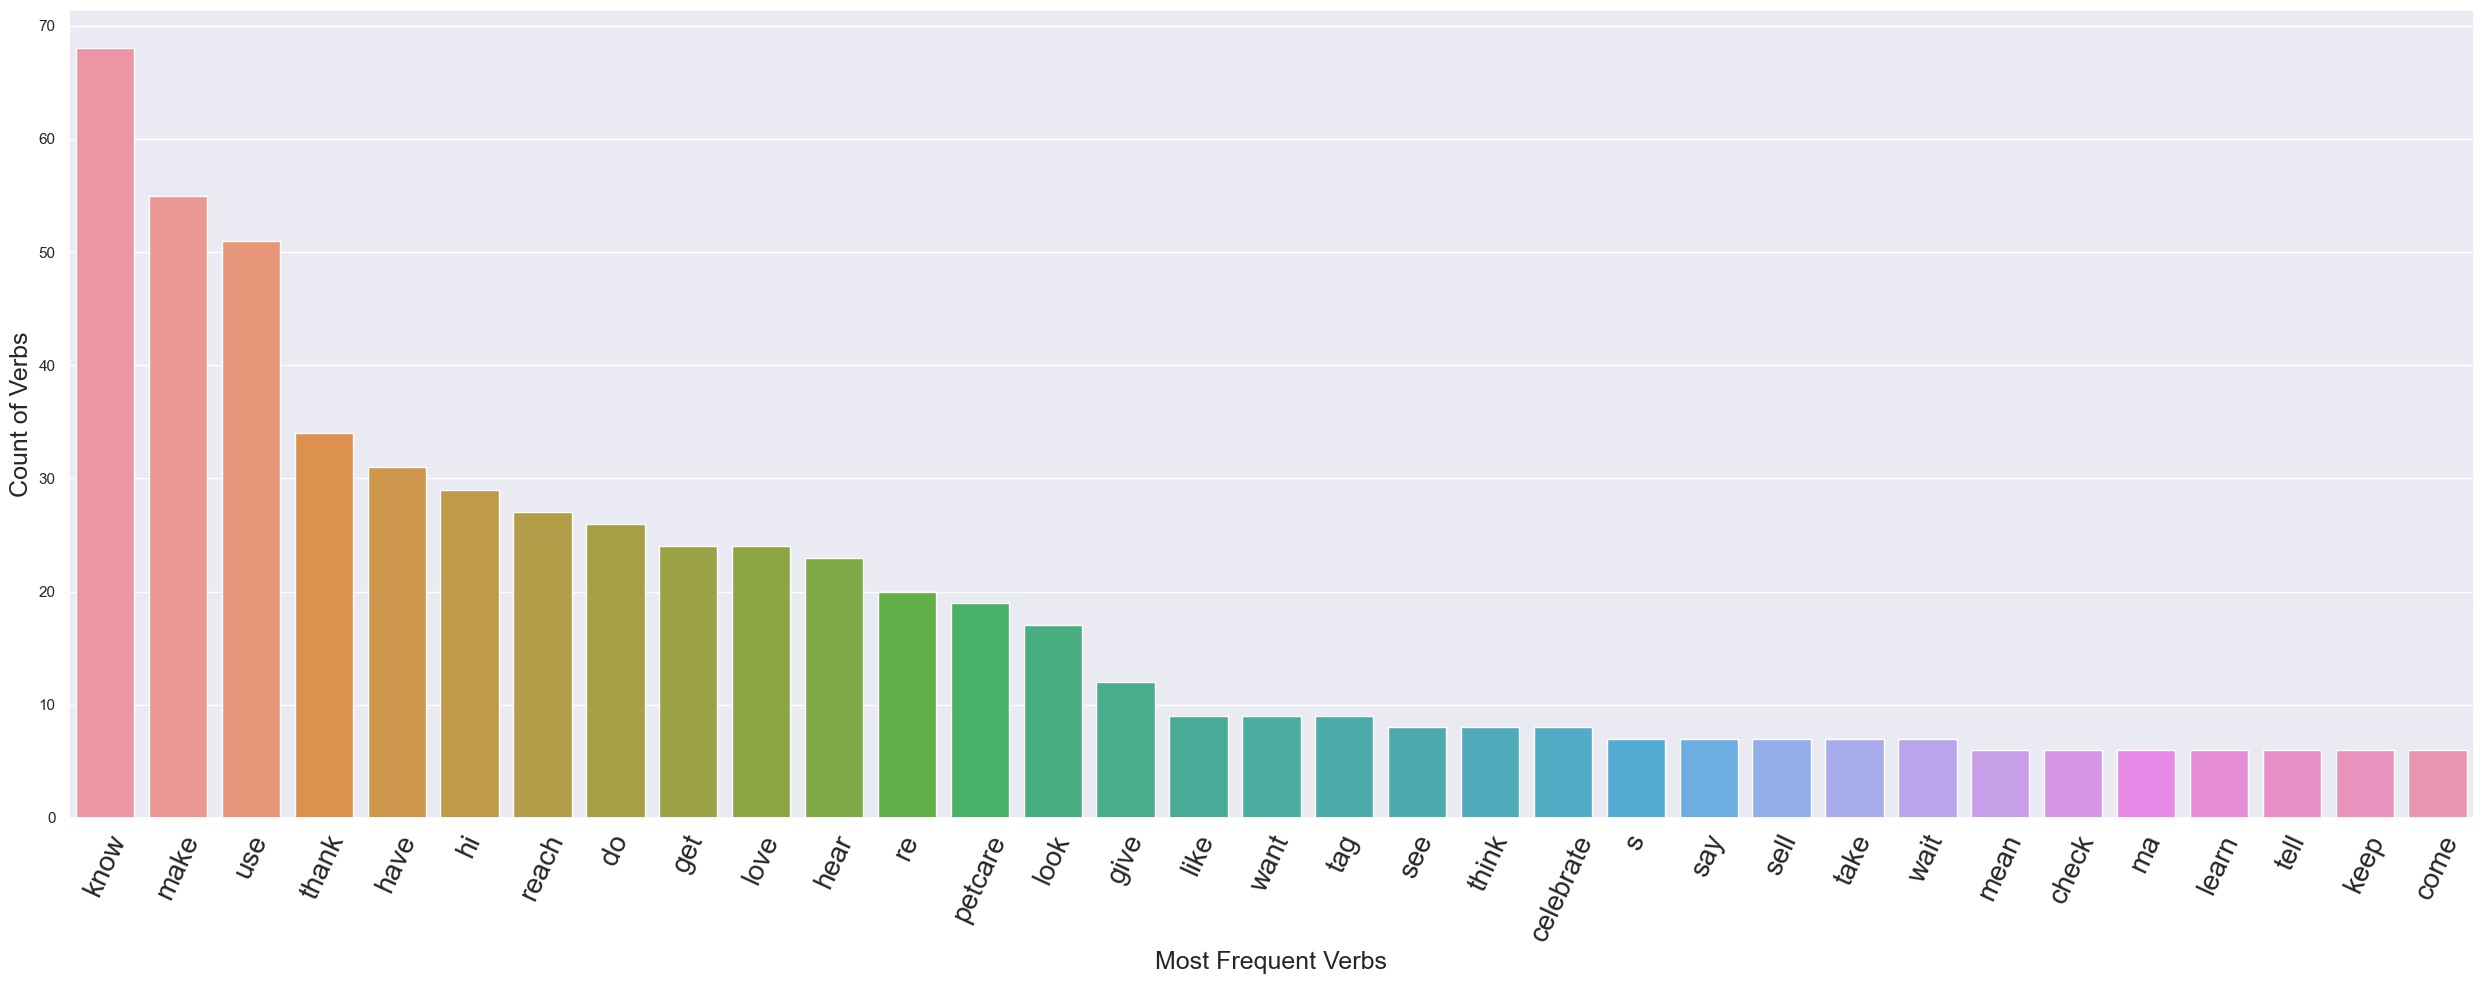

In [181]:
sns.barplot(x='VERB', y='count', data=verbs_df.query('count > 5').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(25,10)})
plt.xlabel('Most Frequent Verbs', fontsize=18)
plt.ylabel('Count of Verbs', fontsize=18)
plt.xticks(rotation = 65, fontsize=20)
plt.tight_layout()
plt.savefig('Count for Frequent Verbs')
plt.show()

In [182]:
dict_bluebuffalo = top_n_Verbs(nlp_bluebuffalo, 3)
dict_DiamondPetFood = top_n_Verbs(nlp_DiamondPetFood, 3)
dict_Purina = top_n_Verbs(nlp_Purina, 3)
dict_wellnesspetfood = top_n_Verbs(nlp_wellnesspetfood, 3)

In [183]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Verbs_df_bluebuffalo = pd.DataFrame.from_dict(dict_bluebuffalo)
Verbs_df_bluebuffalo = Verbs_df_bluebuffalo.sort_values(by=['VERB'], ascending=False)
Verbs_df_bluebuffalo.reset_index(inplace=True)
Verbs_df_bluebuffalo.rename(columns={'VERB':'count'}, inplace=True)
Verbs_df_bluebuffalo.rename(columns={'index':'VERB'}, inplace=True)
Verbs_df_bluebuffalo.columns

Index(['VERB', 'count'], dtype='object')

In [184]:
Verbs_df_bluebuffalo.head()

,VERB,count
0,thank,13
1,love,11
2,like,5
3,make,5
4,oughe,5


In [185]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Verbs_df_Purina = pd.DataFrame.from_dict(dict_Purina)
Verbs_df_Purina = Verbs_df_Purina.sort_values(by=['VERB'], ascending=False)
Verbs_df_Purina.reset_index(inplace=True)
Verbs_df_Purina.rename(columns={'VERB':'count'}, inplace=True)
Verbs_df_Purina.rename(columns={'index':'VERB'}, inplace=True)
#Verbs_df_Purina.columns
Verbs_df_Purina.head()

,VERB,count
0,know,61
1,use,50
2,make,37
3,hi,29
4,do,20


In [186]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Verbs_df_DiamondPetFood = pd.DataFrame.from_dict(dict_DiamondPetFood)
Verbs_df_DiamondPetFood = Verbs_df_DiamondPetFood.sort_values(by=['VERB'], ascending=False)
Verbs_df_DiamondPetFood.reset_index(inplace=True)
Verbs_df_DiamondPetFood.rename(columns={'VERB':'count'}, inplace=True)
Verbs_df_DiamondPetFood.rename(columns={'index':'VERB'}, inplace=True)
#Verbs_df_DiamondPetFood.columns
Verbs_df_DiamondPetFood.head()

,VERB,count
0,give,10
1,love,7
2,get,6
3,have,6
4,thank,6


In [187]:
# Make a dataframes and sort from highest count to lowest for the entire set of tweets
Verbs_df_wellnesspetfood = pd.DataFrame.from_dict(dict_wellnesspetfood)
Verbs_df_wellnesspetfood = Verbs_df_wellnesspetfood.sort_values(by=['VERB'], ascending=False)
Verbs_df_wellnesspetfood.reset_index(inplace=True)
Verbs_df_wellnesspetfood.rename(columns={'VERB':'count'}, inplace=True)
Verbs_df_wellnesspetfood.rename(columns={'index':'VERB'}, inplace=True)
Verbs_df_wellnesspetfood.columns
Verbs_df_wellnesspetfood.head()

,VERB,count
0,have,19
1,get,12
2,hear,11
3,look,10
4,celebrate,8


In [188]:
Verbs_df_wellnesspetfood['UserName'] = 'wellnesspetfood'
Verbs_df_Purina['UserName'] = 'Purina'
Verbs_df_DiamondPetFood['UserName'] = 'DiamondPetFood'
Verbs_df_bluebuffalo['UserName'] = 'bluebuffalo'


In [189]:
Verbs_df_bluebuffalo.head()

,VERB,count,UserName
0,thank,13,bluebuffalo
1,love,11,bluebuffalo
2,like,5,bluebuffalo
3,make,5,bluebuffalo
4,oughe,5,bluebuffalo


In [190]:
frames = [Verbs_df_Purina, Verbs_df_bluebuffalo, Verbs_df_DiamondPetFood, Verbs_df_wellnesspetfood]
df_Verbs_count = pd.concat(frames)

In [191]:
df_Verbs_count.UserName.value_counts()

Purina             17
DiamondPetFood     12
wellnesspetfood    12
bluebuffalo         6
Name: UserName, dtype: int64

In [192]:
df_Verbs_count.to_csv('Verbs_count.csv', index=False)

In [193]:
# Had to restart Kernel
#df_Verbs_count = pd.read_csv('Verbs_count.csv')

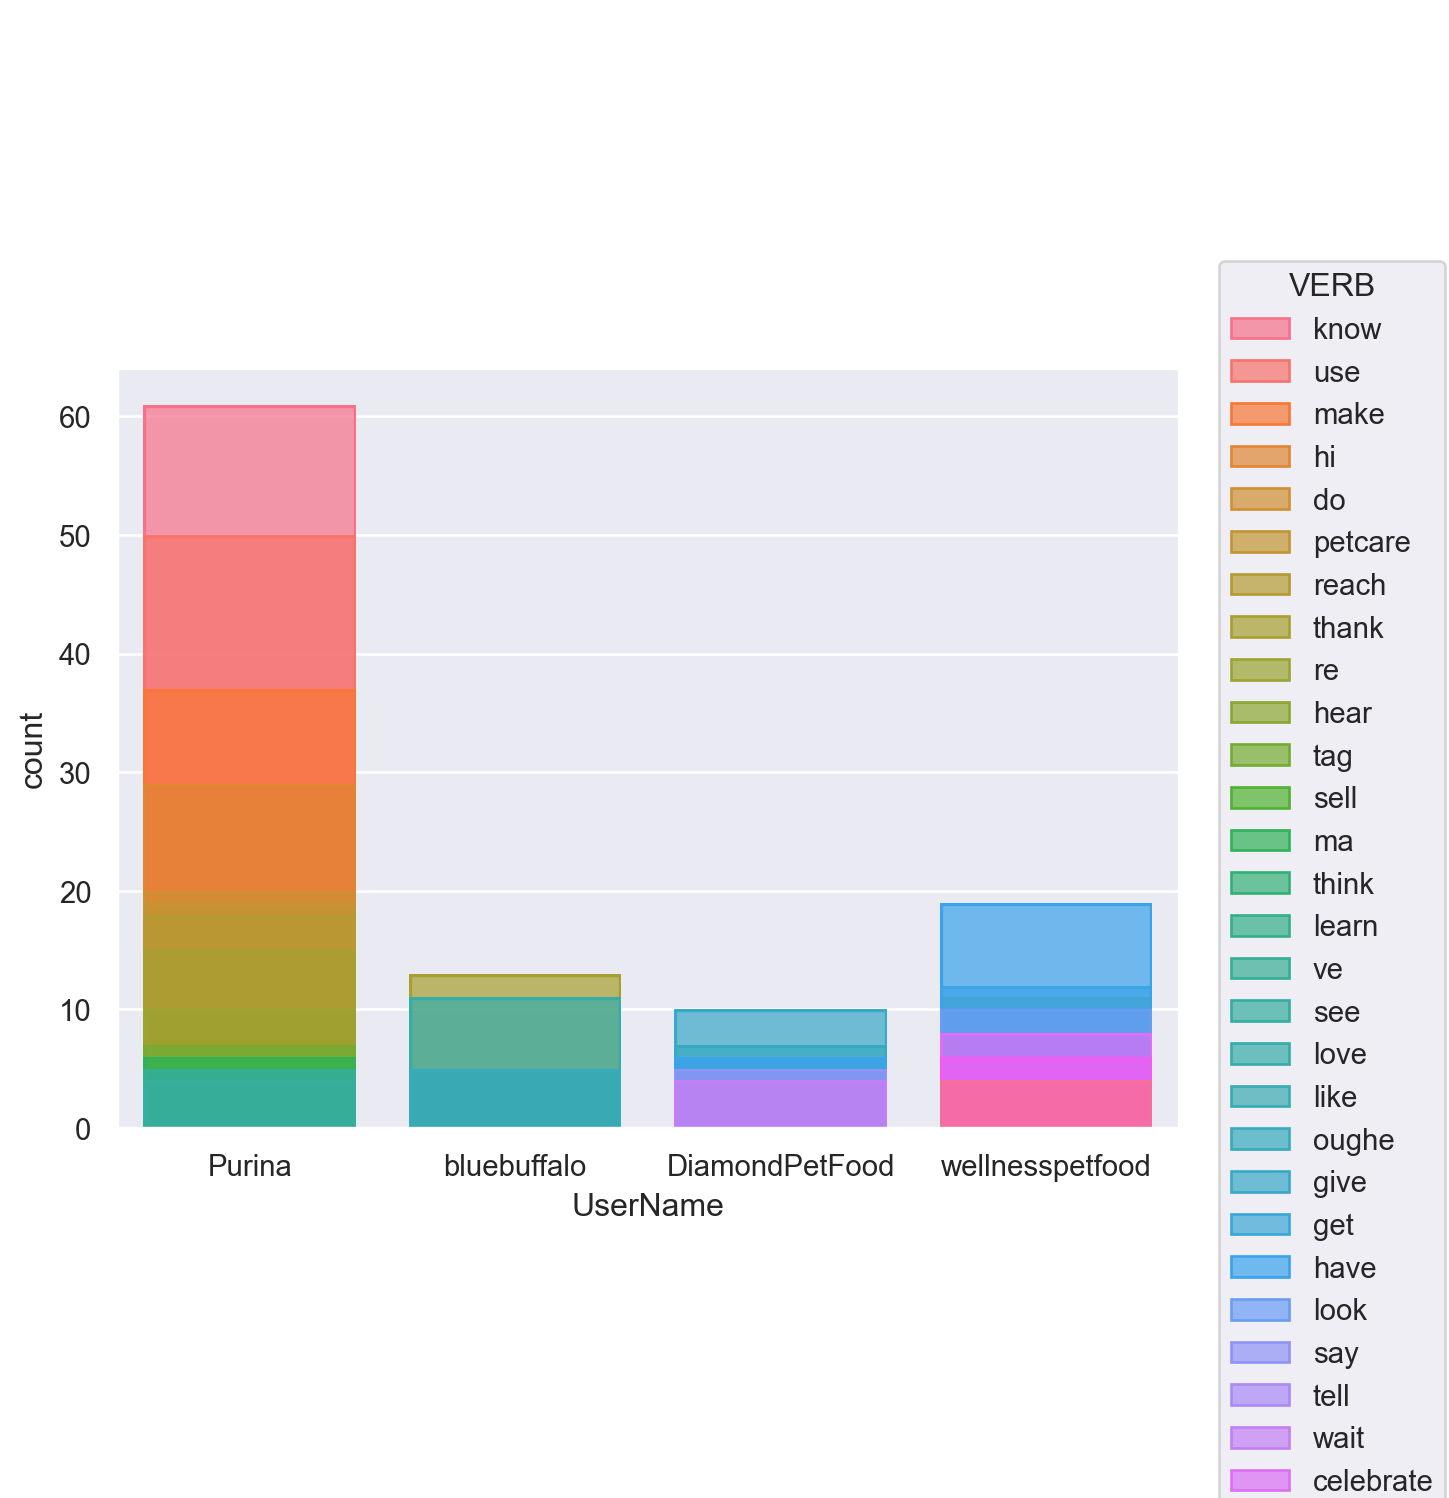

In [194]:
(
    so.Plot(df_Verbs_count, x="UserName", y="count", color="VERB")
    .add(so.Bar(), so.Agg())
    
)


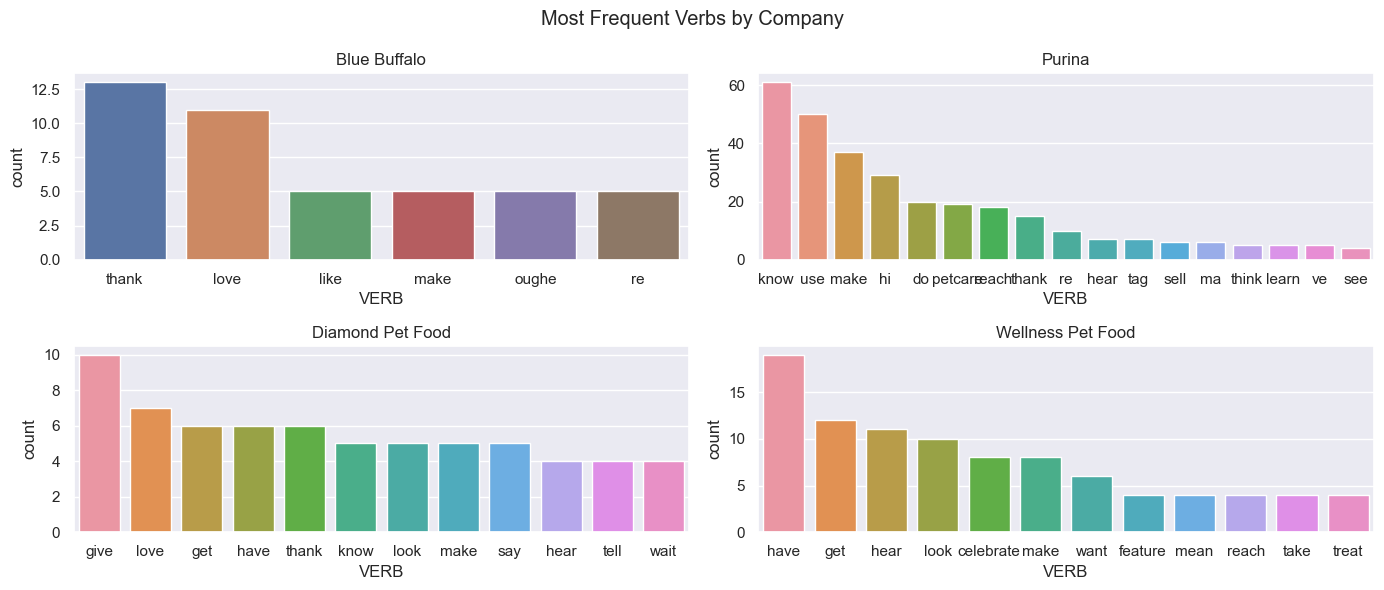

In [195]:
##trying again from matplotlib setup
figure, axes = plt.subplots(2, 2, sharex=False, figsize=(14,6))
figure.suptitle('Most Frequent Verbs by Company')
sns.barplot(ax=axes[0, 0], x='VERB', y='count', data=df_Verbs_count[df_Verbs_count.UserName == 'bluebuffalo']).set(title='Blue Buffalo')
sns.barplot(ax=axes[0, 1], x='VERB', y='count', data=df_Verbs_count[df_Verbs_count.UserName == 'Purina']).set(title='Purina')
sns.barplot(ax=axes[1, 0], x='VERB', y='count', data=df_Verbs_count[df_Verbs_count.UserName == 'DiamondPetFood']).set(title='Diamond Pet Food')
sns.barplot(ax=axes[1, 1], x='VERB', y='count', data=df_Verbs_count[df_Verbs_count.UserName == 'wellnesspetfood']).set(title='Wellness Pet Food')
margin_titles=True
#plt.xticks(rotation = 60, fontsize=12)
plt.tight_layout()
plt.savefig('By Company Count for Frequent Verbs')

We have a sense of the verbs in each comany's set of Tweets. Purina certainly "know"s a lot compared to the other companies. Blue Buffalo is very thankful and full of love. Diamond is all about giving. Wellness is interestingly focused on having and getting.

In [196]:
#With a bit of help from Datacamp
# Returns number of proper verbs
def count_Verbs(text, model=nlp):
  	# Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper ADJs
    return pos.count('VERB')

In [197]:
#testing this out
test_text = "Thirsty dirty old yellow big chickens sit and crush their nests"
count_Verbs(test_text)

2

In [198]:
df['Count_VERBS'] = df['Full_Tweets'].apply(lambda x: count_Verbs(x))

In [199]:
df.tail()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS
793,96,2022-11-30 19:49:06+00:00,DiamondPetFood,harness on outdoor adventure ready katad...,https://t.co/twWB3oWDFH,NaN,0,48,2,3,0
794,113,2022-11-30 19:47:06+00:00,DiamondPetFood,finley has his paws crossed because he is a ge...,https://t.co/baHt2b3yxD,NaN,0,48,1,3,2
795,96,2022-11-29 19:48:02+00:00,DiamondPetFood,sorry i have plans the plans petting my...,httpNone,NaN,0,48,1,5,4
796,95,2022-11-29 19:47:06+00:00,DiamondPetFood,hermes loves dates at the dog park anybody el...,https://t.co/DIAAi3VbUX,NaN,0,48,0,3,1
797,80,2022-11-28 21:45:06+00:00,DiamondPetFood,where did all of these cardboard boxes come f...,https://t.co/Kr8AlRG8GD,NaN,0,48,0,2,1


In [200]:
df.to_csv('SA_df.csv', index=False)

## Sentiment Analysis

In [201]:
# Will try with spaCy first:
import eng_spacysentiment

In [202]:
nlp2 = eng_spacysentiment.load()

In [203]:
#testing out here
text = "Welcome to Arsenals official YouTube channel Watch as we take you closer and show you the personality of the club"
doc = nlp2(text) #from before
print(doc.cats)

{'positive': 0.9402117729187012, 'negative': 0.05978821963071823}


In [204]:
#With a bit of help from Datacamp
# Returns number of proper verbs
def sentiment_positive(text, model=nlp2):
  	# Create doc object
    doc = model(text)
    # Generate list of POS tags
    sentiment = doc.cats
    for k,s in sentiment.items():
        if k == 'positive':           
            return s #returning positive score

In [205]:
#testing this out
test_text = "Thirsty dirty old yellow big chickens sit and crush their nests"
sentiment_positive(test_text)

0.993593156337738

In [206]:
df['Positive_sentiment'] = df['Full_Tweets'].apply(lambda x: sentiment_positive(x))

In [207]:
df.tail()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment
793,96,2022-11-30 19:49:06+00:00,DiamondPetFood,harness on outdoor adventure ready katad...,https://t.co/twWB3oWDFH,NaN,0,48,2,3,0,8.010480e-01
794,113,2022-11-30 19:47:06+00:00,DiamondPetFood,finley has his paws crossed because he is a ge...,https://t.co/baHt2b3yxD,NaN,0,48,1,3,2,9.999996e-01
795,96,2022-11-29 19:48:02+00:00,DiamondPetFood,sorry i have plans the plans petting my...,httpNone,NaN,0,48,1,5,4,9.999907e-01
796,95,2022-11-29 19:47:06+00:00,DiamondPetFood,hermes loves dates at the dog park anybody el...,https://t.co/DIAAi3VbUX,NaN,0,48,0,3,1,9.025232e-01
797,80,2022-11-28 21:45:06+00:00,DiamondPetFood,where did all of these cardboard boxes come f...,https://t.co/Kr8AlRG8GD,NaN,0,48,0,2,1,8.154991e-09


In [208]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Tweet_Length,798.0,96.575188,48.418178,1.000000e+01,44.0000,124.000000,140.00000,144.0
Mention_Count,798.0,0.708020,0.512049,0.000000e+00,0.0000,1.000000,1.00000,3.0
Count_ADJs,798.0,0.899749,1.014314,0.000000e+00,0.0000,1.000000,1.00000,6.0
Count_NOUNS,798.0,2.754386,2.269723,0.000000e+00,1.0000,3.000000,4.00000,13.0
Count_VERBS,798.0,1.843358,1.455065,0.000000e+00,1.0000,2.000000,3.00000,7.0
Positive_sentiment,798.0,0.595527,0.440715,1.486091e-14,0.0124,0.896225,0.99986,1.0


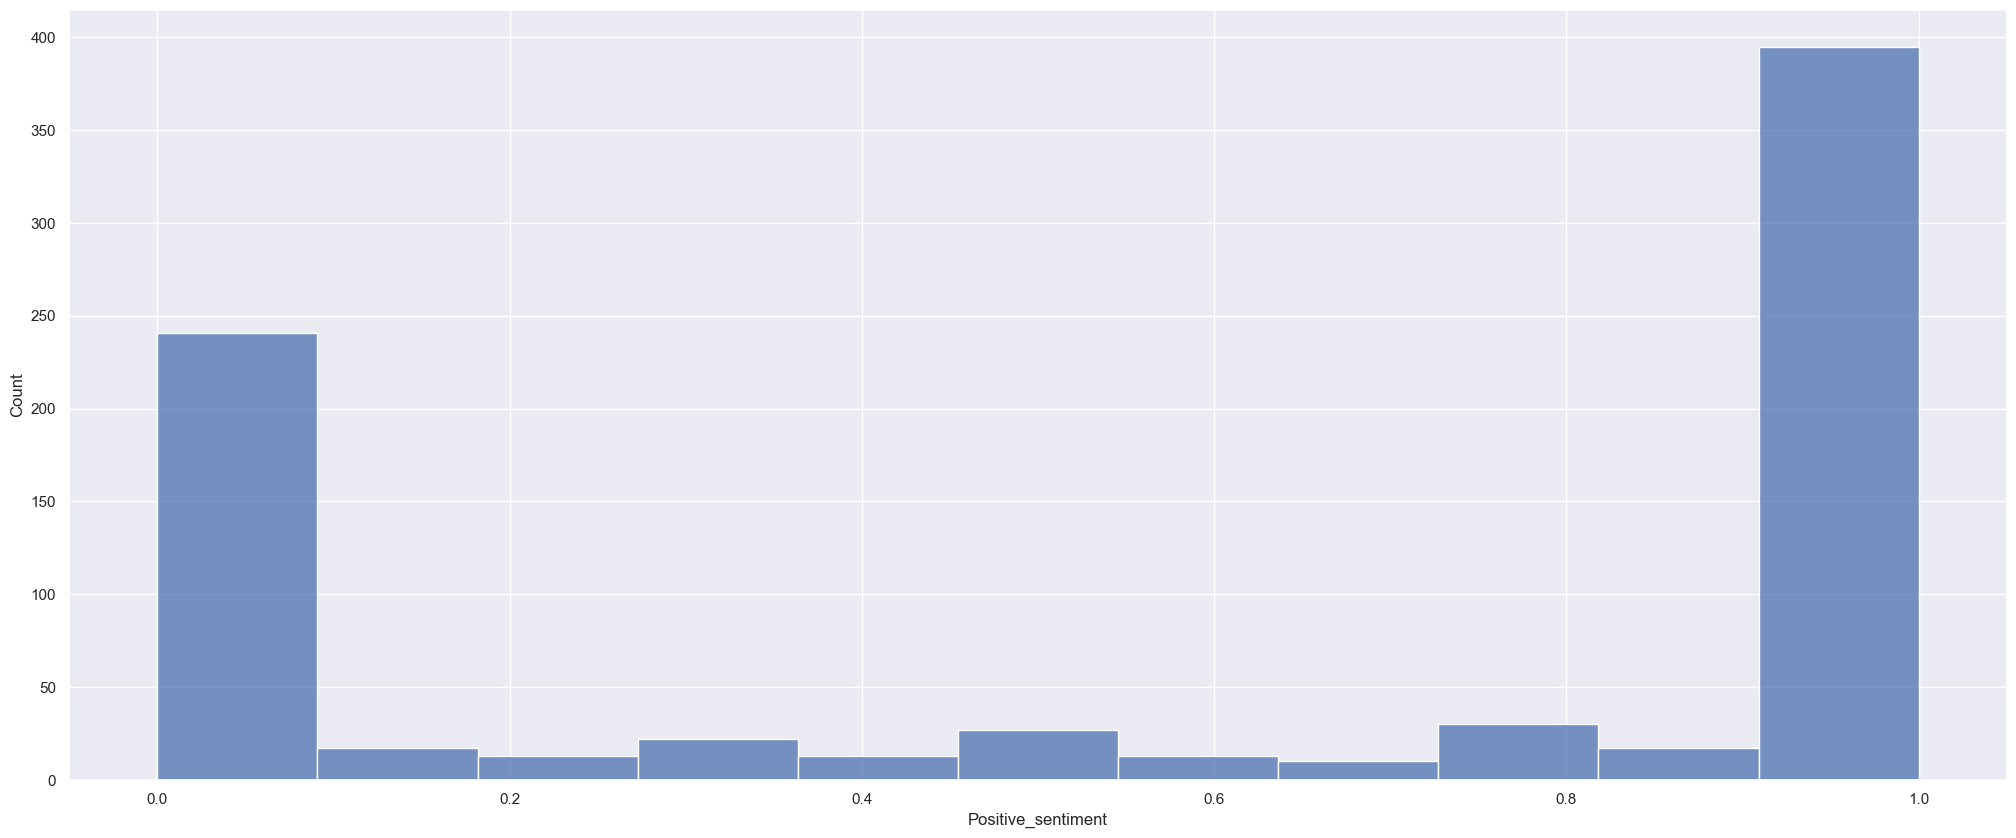

In [209]:
sns.histplot(data=df, x="Positive_sentiment")
plt.savefig('Positive Sentiment Scores.png')
#with this kind of divide in the Positive scores, I am going to go with two bins

In [210]:
#using qcut here: https://pandas.pydata.org/docs/reference/api/pandas.qcut.html#pandas.qcut
df['sentiment_cut']=pd.qcut(df['Positive_sentiment'], 2, labels=[1,0])

In [211]:
df.sentiment_cut.value_counts()

1    399
0    399
Name: sentiment_cut, dtype: int64

In [212]:
df.to_csv('SA_df.csv', index=False)

In [213]:
df=pd.read_csv('SA_df.csv')

In [214]:
df.head()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment,sentiment_cut
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1,6,2,2,4,0.000050,1
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1,6,2,1,4,0.000171,1
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1,6,1,2,4,0.971268,0
3,144,2023-02-09 05:00:15+00:00,Purina,thanks for reaching out about alpo come get...,https://t.co/VsPUdZPWfP,waffletower,1,6,2,2,4,0.975506,0
4,94,2023-02-08 20:44:37+00:00,Purina,we can t keep our tails from wagging in antic...,httpNone,OpenDoorAnimals,1,6,0,3,3,0.000001,1


In [215]:
[(ent.text, ent.label_) for ent in doc.ents]

[]

In [216]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Tweet_Length,798.0,96.575188,48.418178,1.000000e+01,44.0000,124.000000,140.00000,144.0
Mention_Count,798.0,0.708020,0.512049,0.000000e+00,0.0000,1.000000,1.00000,3.0
Week,798.0,16.474937,18.685638,1.000000e+00,4.0000,5.000000,34.00000,52.0
Count_ADJs,798.0,0.899749,1.014314,0.000000e+00,0.0000,1.000000,1.00000,6.0
Count_NOUNS,798.0,2.754386,2.269723,0.000000e+00,1.0000,3.000000,4.00000,13.0
Count_VERBS,798.0,1.843358,1.455065,0.000000e+00,1.0000,2.000000,3.00000,7.0
Positive_sentiment,798.0,0.595527,0.440715,1.486091e-14,0.0124,0.896225,0.99986,1.0
sentiment_cut,798.0,0.500000,0.500314,0.000000e+00,0.0000,0.500000,1.00000,1.0


In [217]:
print("Purina mean sentiment:{}".format(round(df[df.UserName == 'Purina'].Positive_sentiment.mean(), 2)),"\n")
print("Blue Buffalo mean sentiment:{}".format(round(df[df.UserName == 'bluebuffalo'].Positive_sentiment.mean(), 2)),"\n")

Purina mean sentiment:0.62 

Blue Buffalo mean sentiment:0.51 



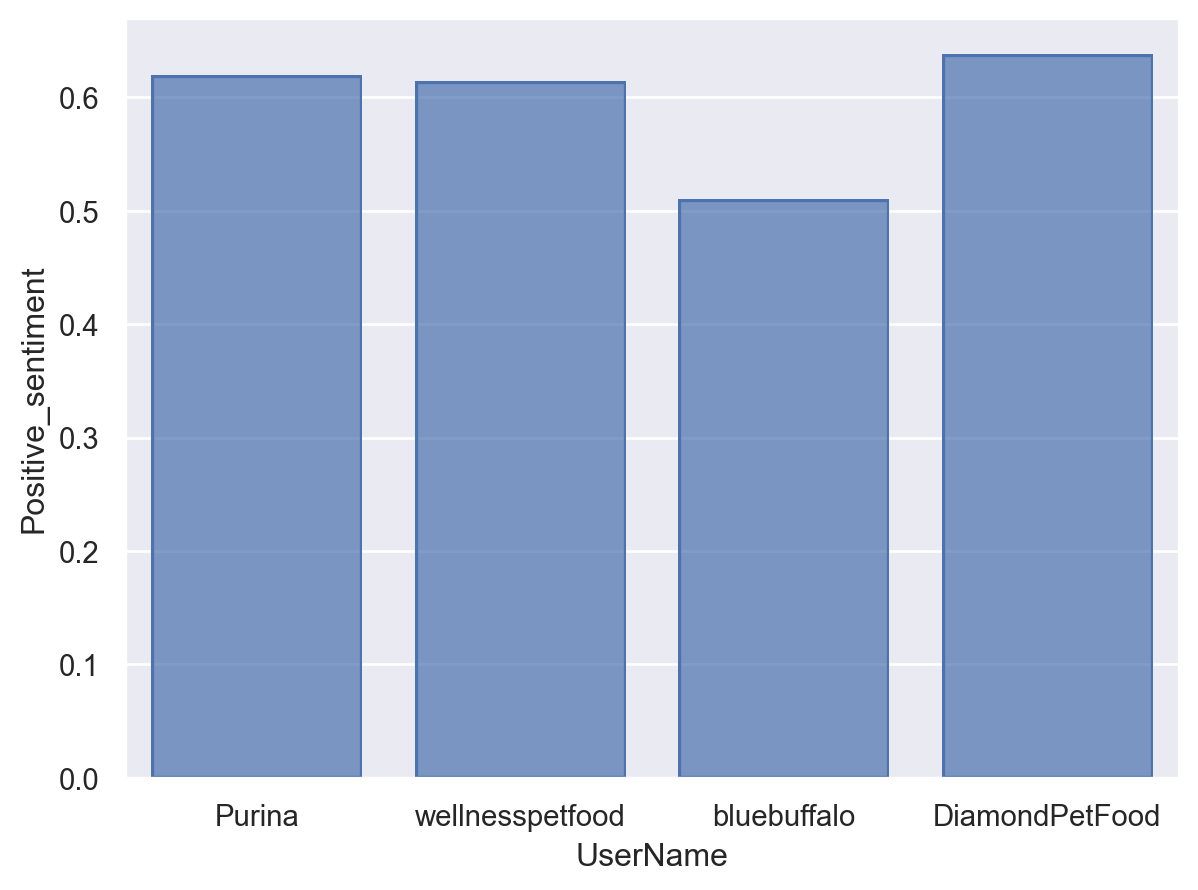

In [218]:
(
    so.Plot(df, x="UserName", y="Positive_sentiment")
    .add(so.Bar(), so.Agg())
    
)


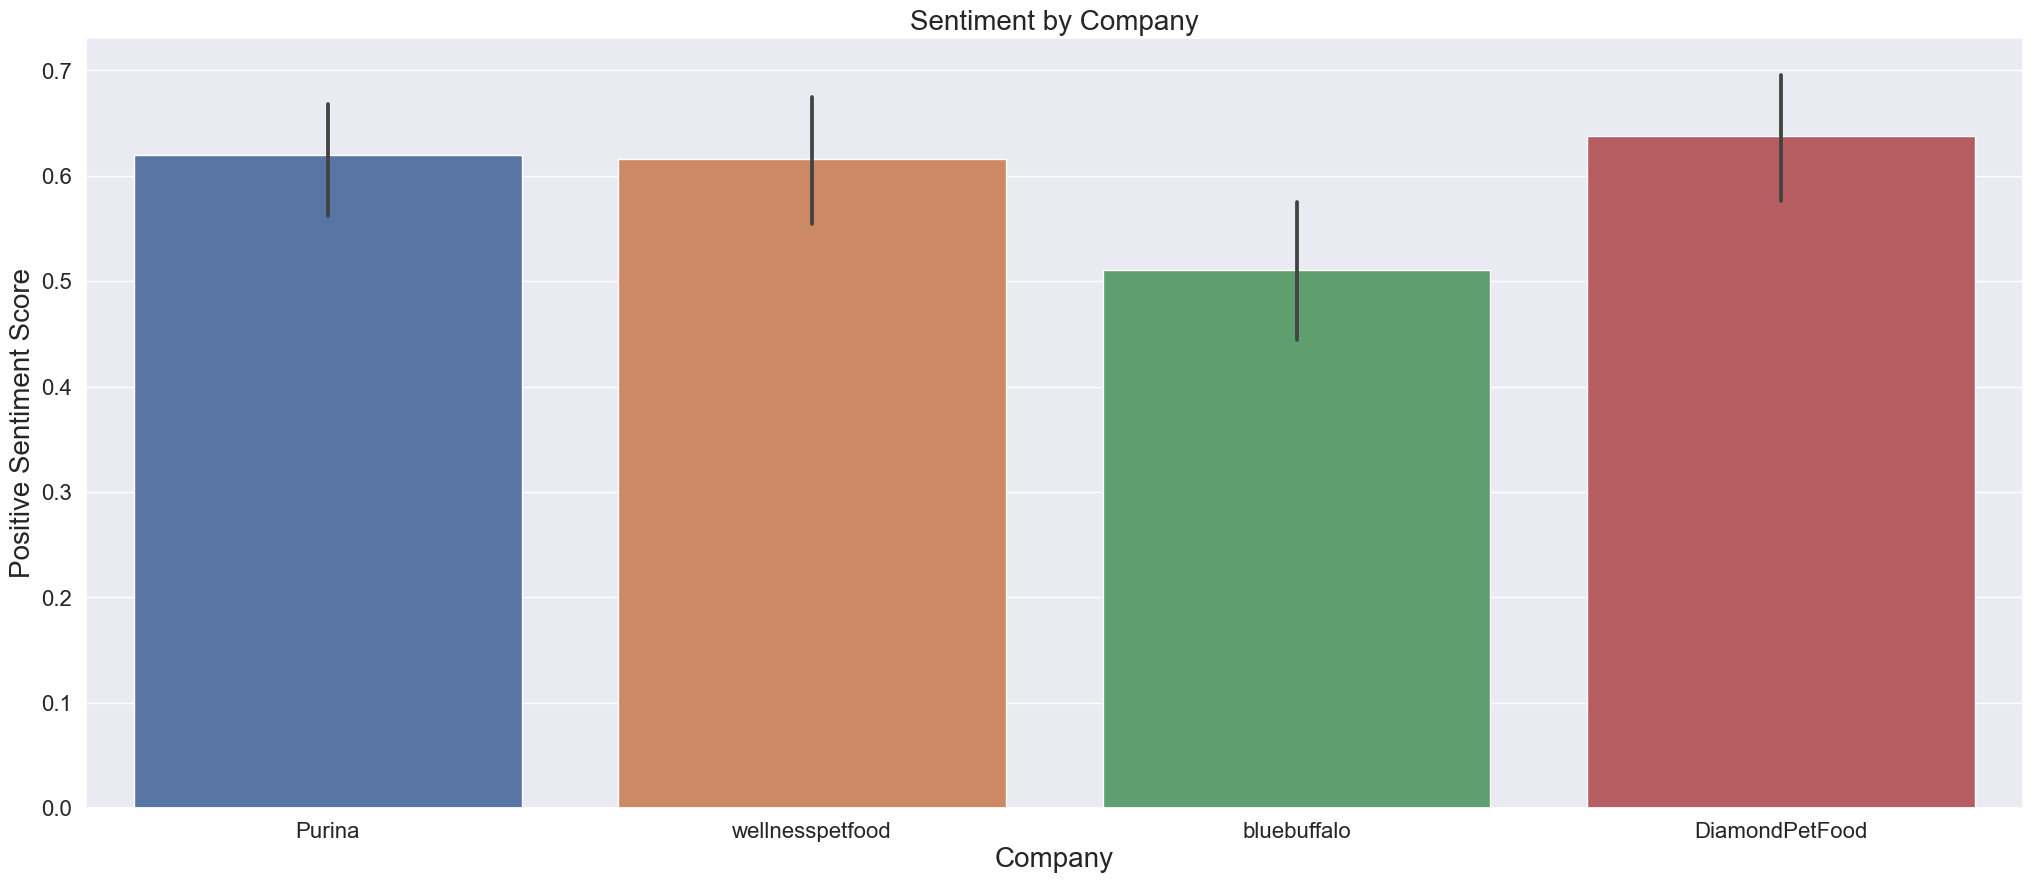

In [290]:
size = 6
sns.barplot(data=df, x="UserName", y="Positive_sentiment")
plt.xlabel('Company', fontsize=20)
plt.ylabel('Positive Sentiment Score', fontsize=20)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(rotation = 0, fontsize=16)
plt.title('Sentiment by Company', fontsize=20)
#plt.tight_layout()
plt.savefig('Avgs and Error by Company')
plt.show()

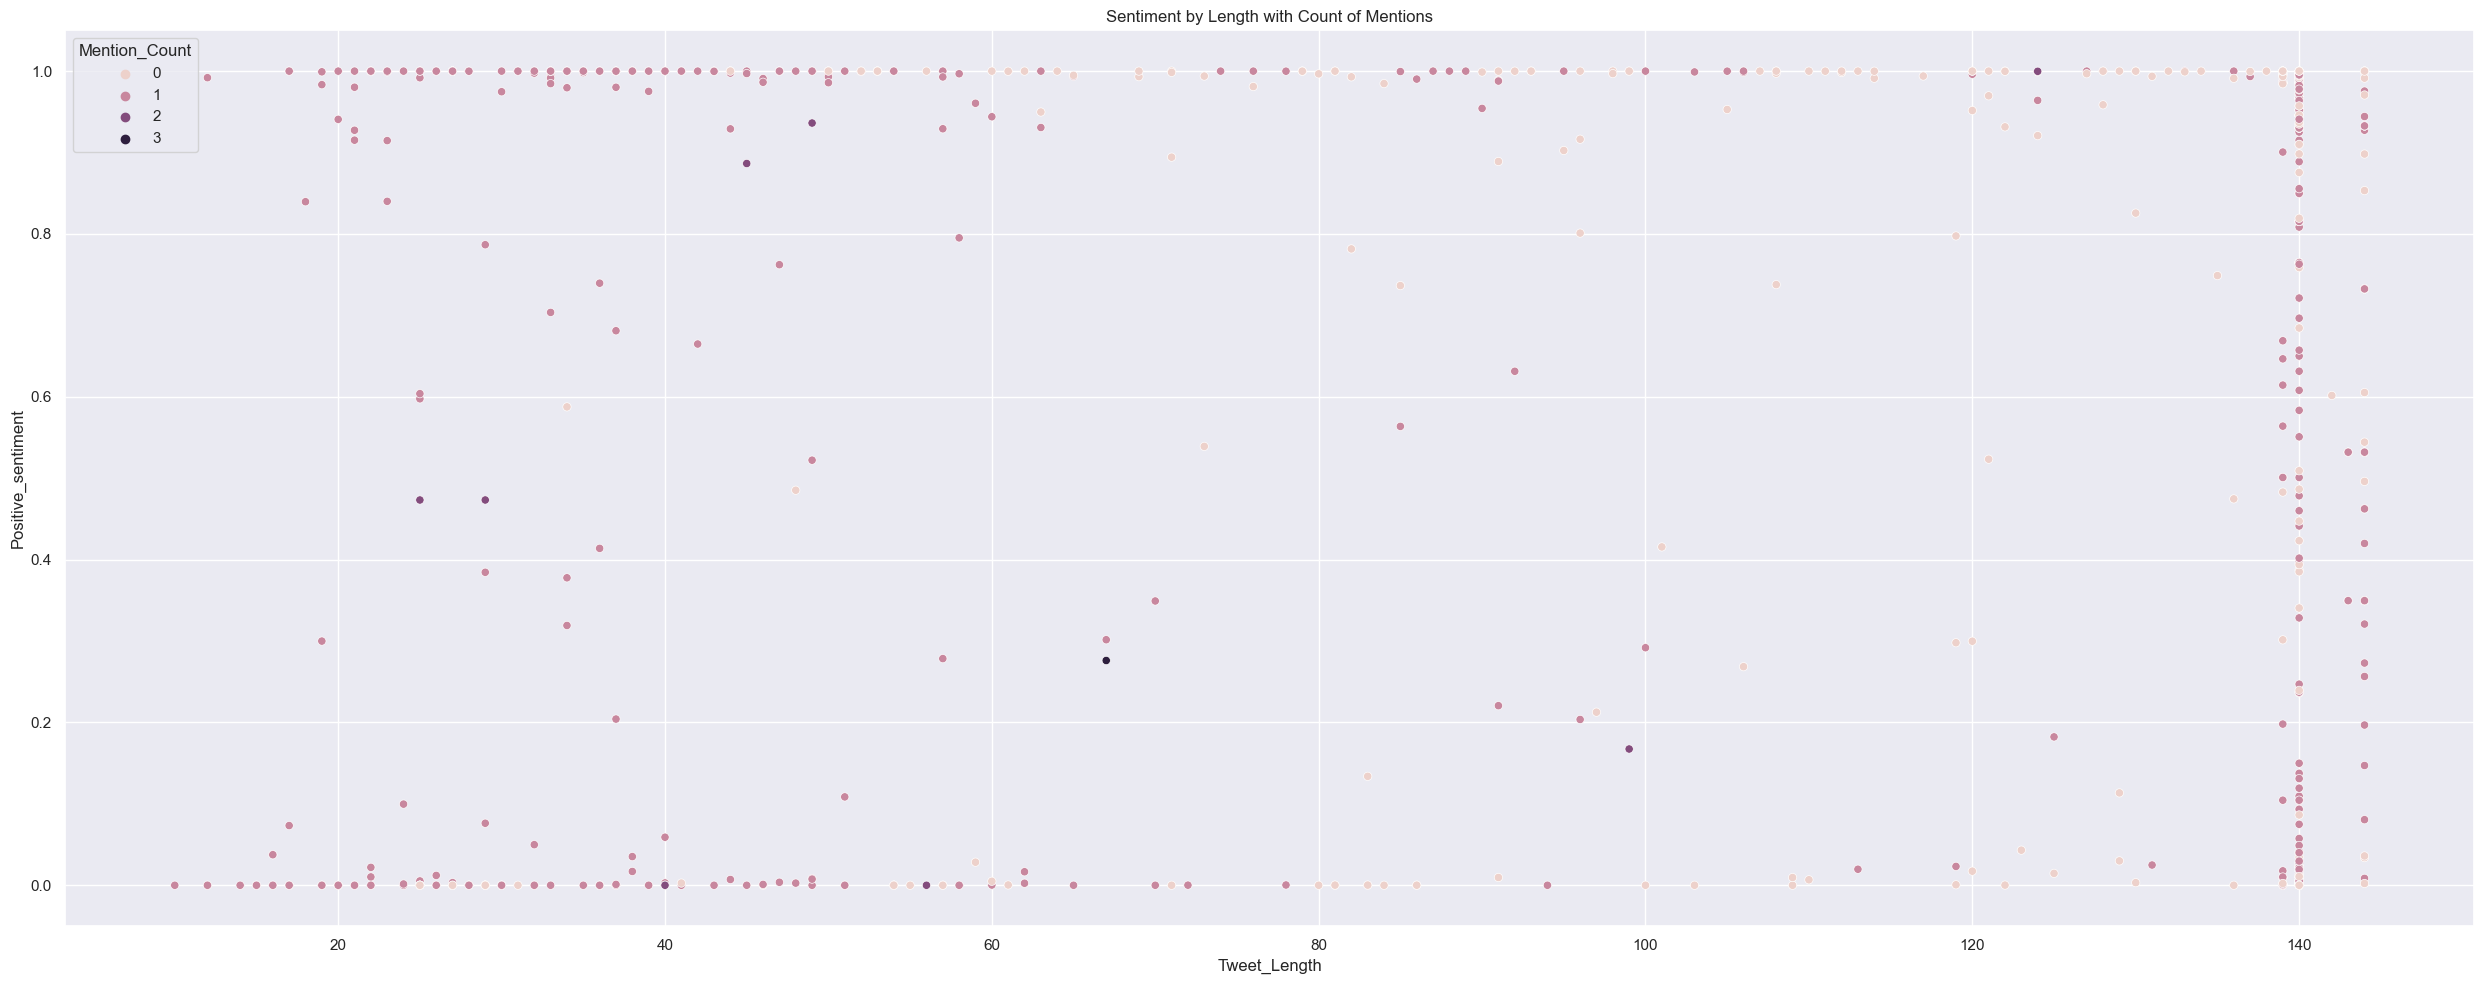

In [186]:
size = 6
sns.scatterplot(data=df, x="Tweet_Length", y="Positive_sentiment", hue="Mention_Count")
ax.set_xlabel('Length of Tweet in Characters')
ax.set_ylabel('Positive Sentiment Score')
plt.title('Sentiment by Length with Count of Mentions')
plt.tight_layout()
plt.savefig('Sentiment by Tweet Length with Mentions')
plt.show()

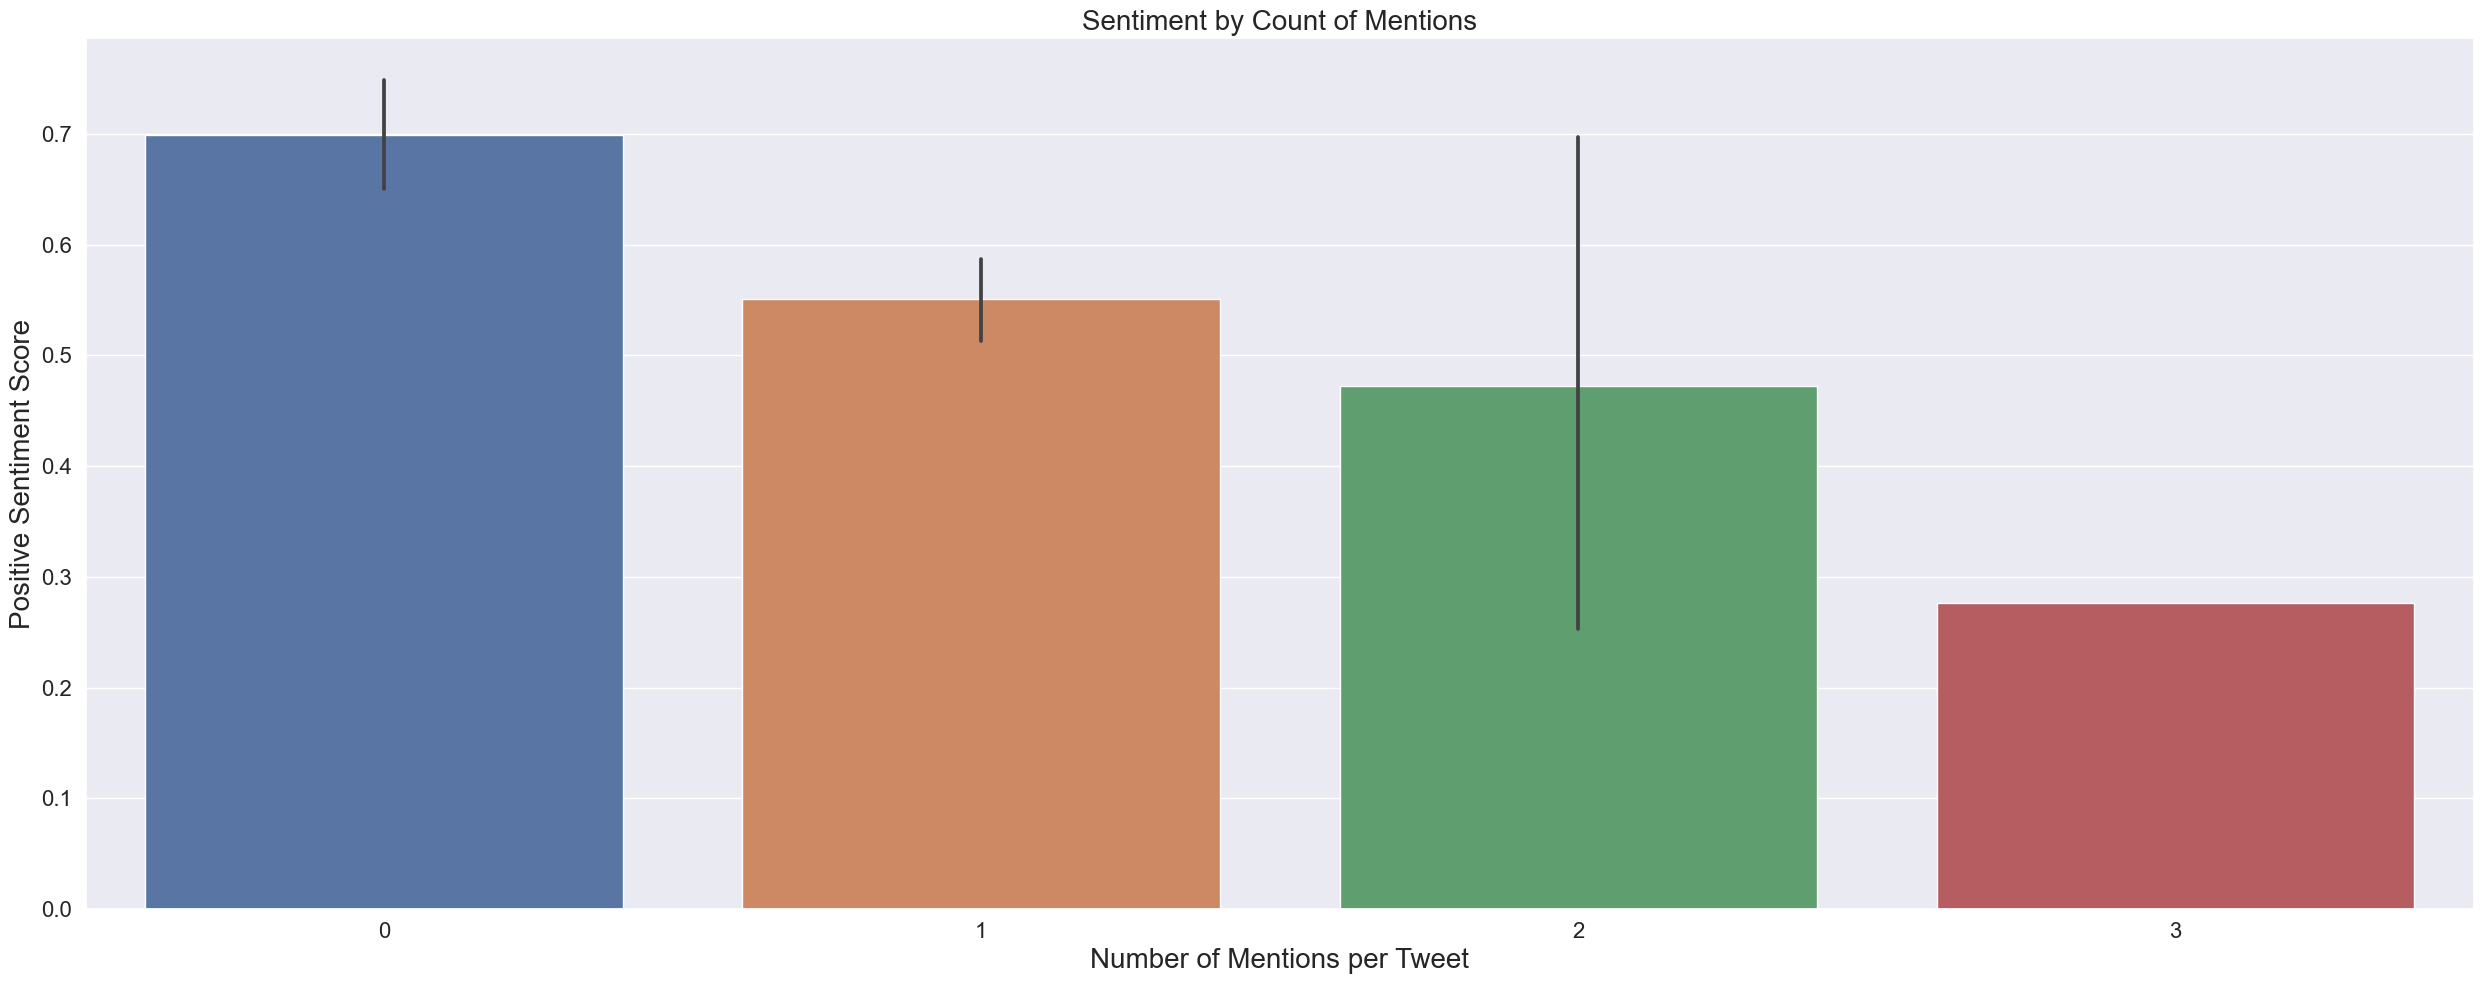

In [295]:
size = 6
sns.barplot(data=df, x="Mention_Count", y="Positive_sentiment")
plt.xlabel('Number of Mentions per Tweet', fontsize=20)
plt.ylabel('Positive Sentiment Score', fontsize=20)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(rotation = 0, fontsize=16)
plt.title('Sentiment by Count of Mentions', fontsize=20)
plt.tight_layout()
plt.savefig('Mentions by Positive Sentiment')
plt.show()
# One pattern that emerges here is that the more mentions, the lower the positivity

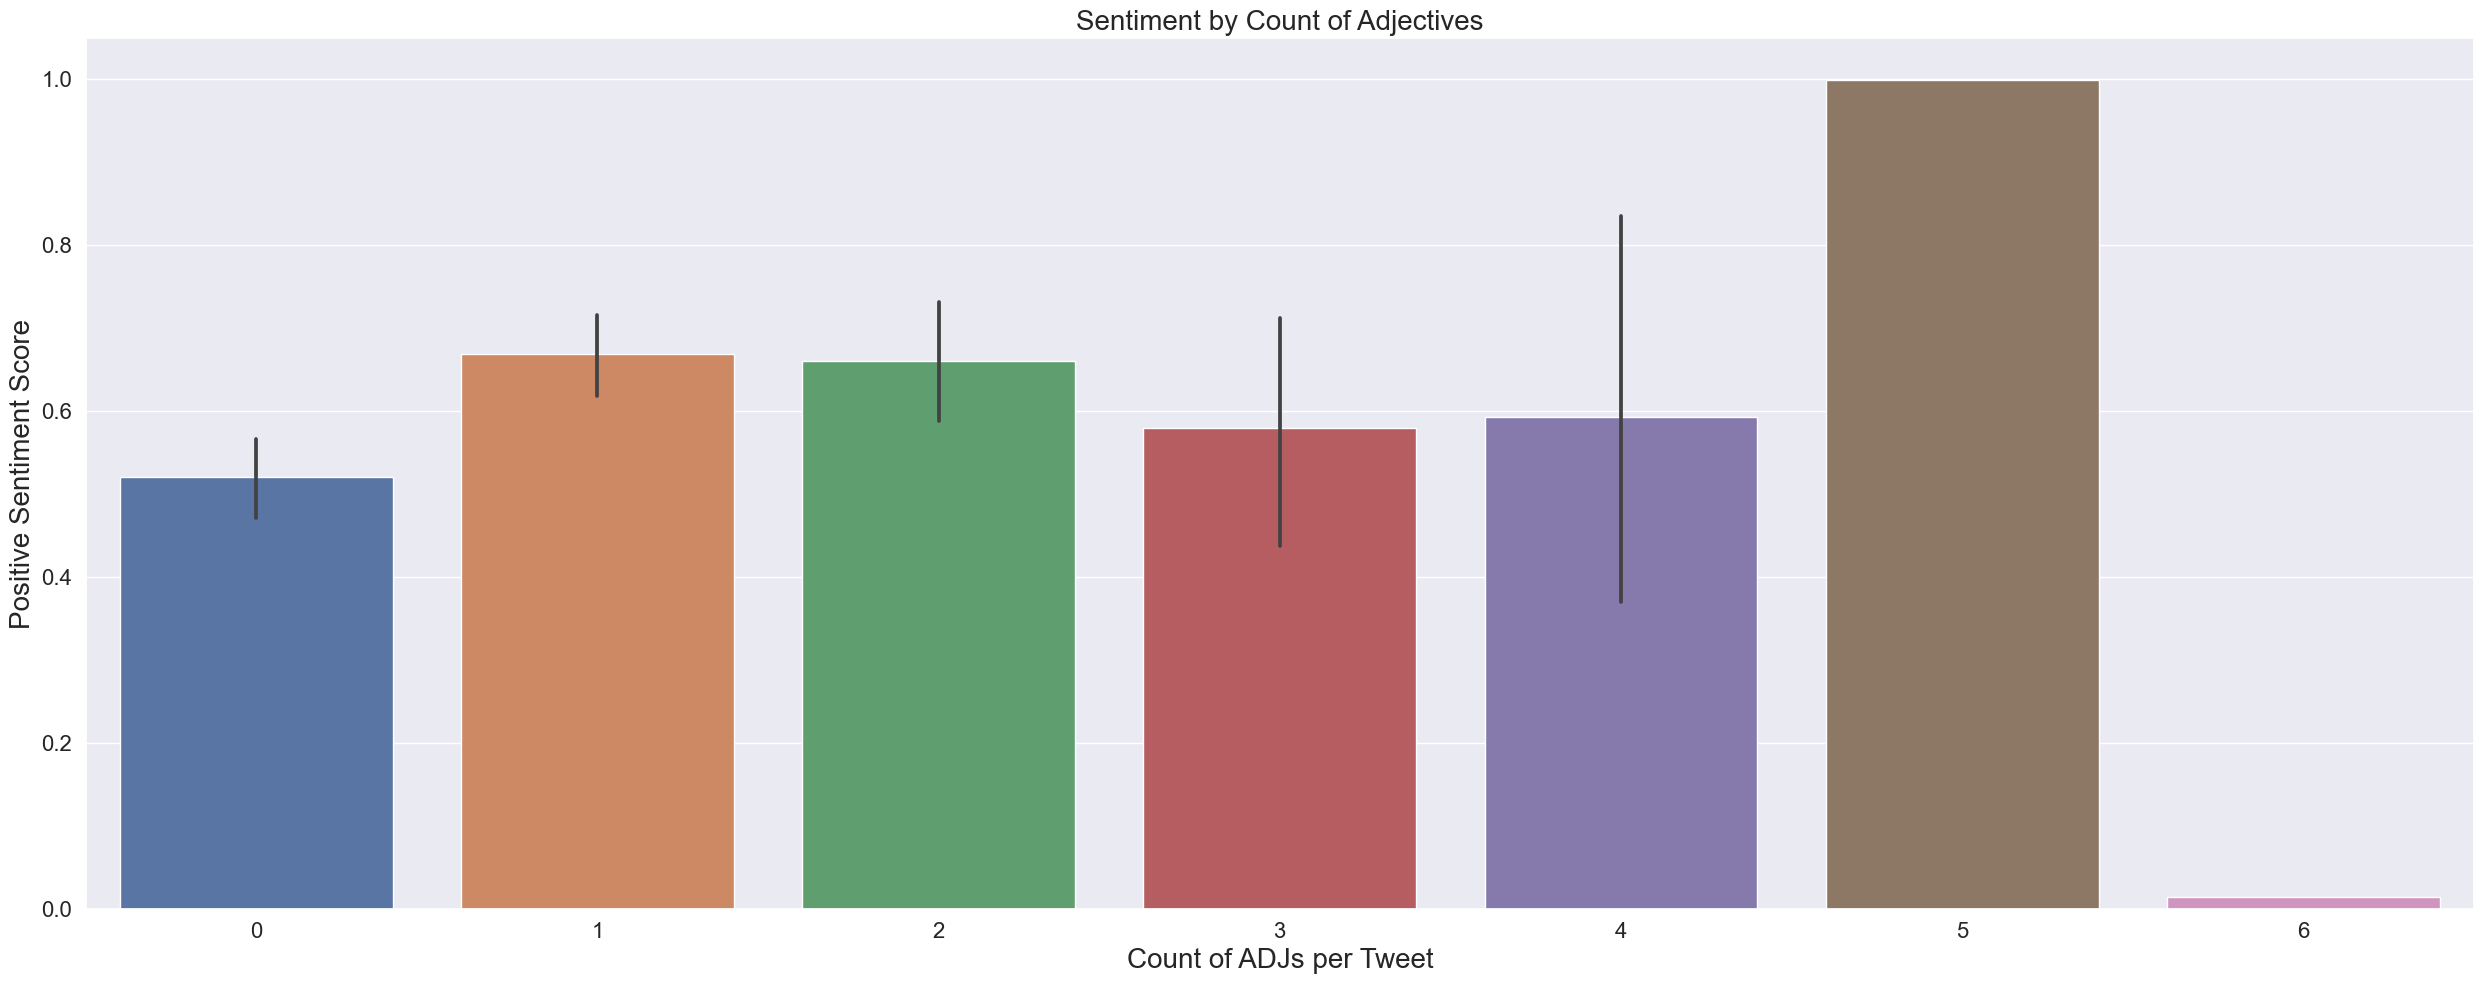

In [297]:
size = 6
sns.barplot(data=df, x="Count_ADJs", y="Positive_sentiment")
plt.xlabel('Count of ADJs per Tweet', fontsize=20)
plt.ylabel('Positive Sentiment Score', fontsize=20)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(rotation = 0, fontsize=16)
plt.title('Sentiment by Count of Adjectives', fontsize=20)
plt.tight_layout()
plt.savefig('Adjectives by Positive Sentiment')
plt.show()


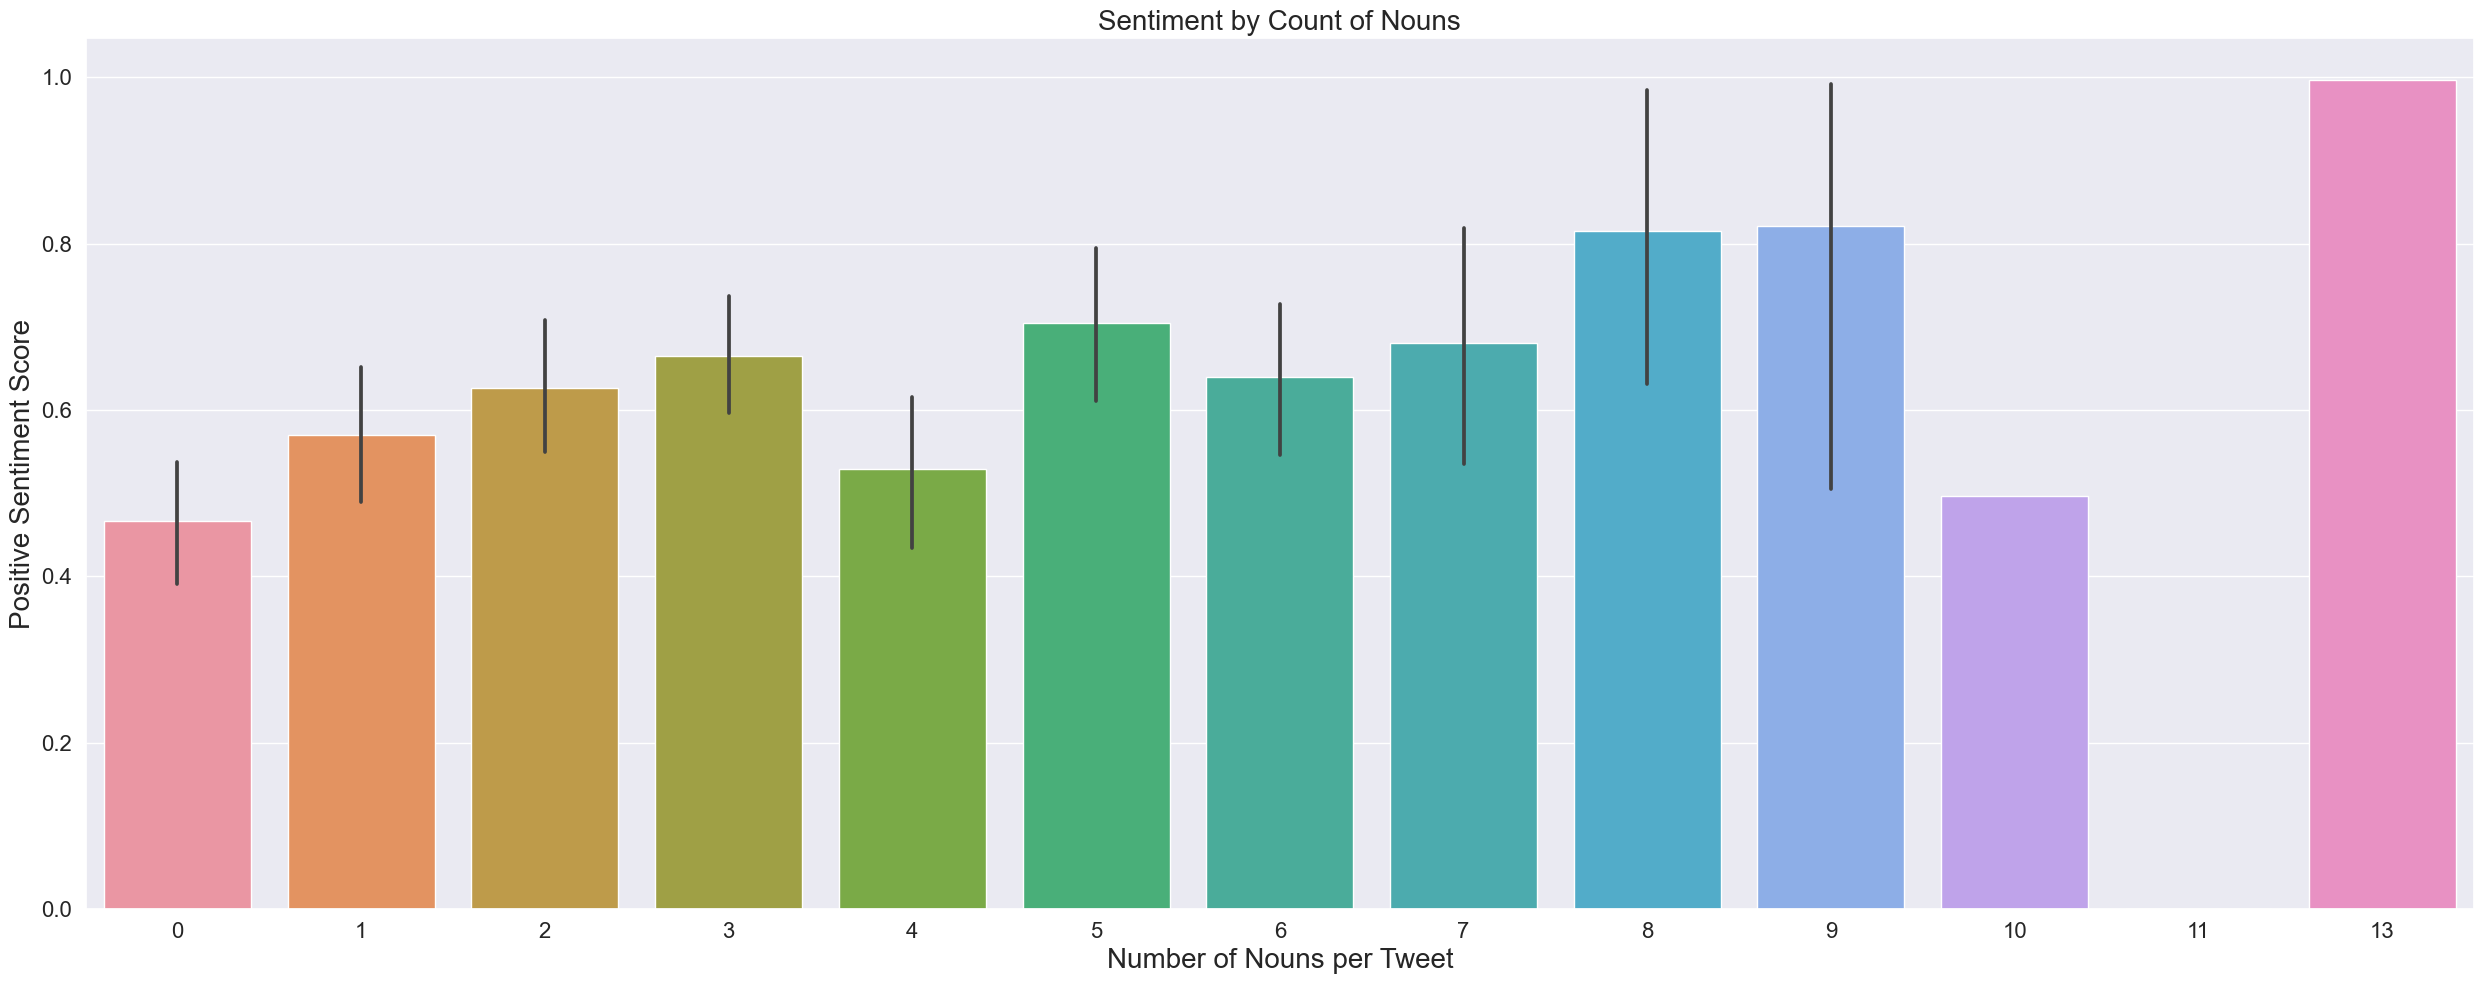

In [299]:
size = 6
sns.barplot(data=df, x="Count_NOUNS", y="Positive_sentiment")
plt.xlabel('Number of Nouns per Tweet', fontsize=20)
plt.ylabel('Positive Sentiment Score', fontsize=20)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(rotation = 0, fontsize=16)
plt.title('Sentiment by Count of Nouns', fontsize=20)
plt.tight_layout()
plt.savefig('Nouns by Positive Sentiment')
plt.show()
# One pattern that emerges here is that a linear relationship appears to obtain (mostly?) for the number of nouns. I wonder where most of the data is for nouns

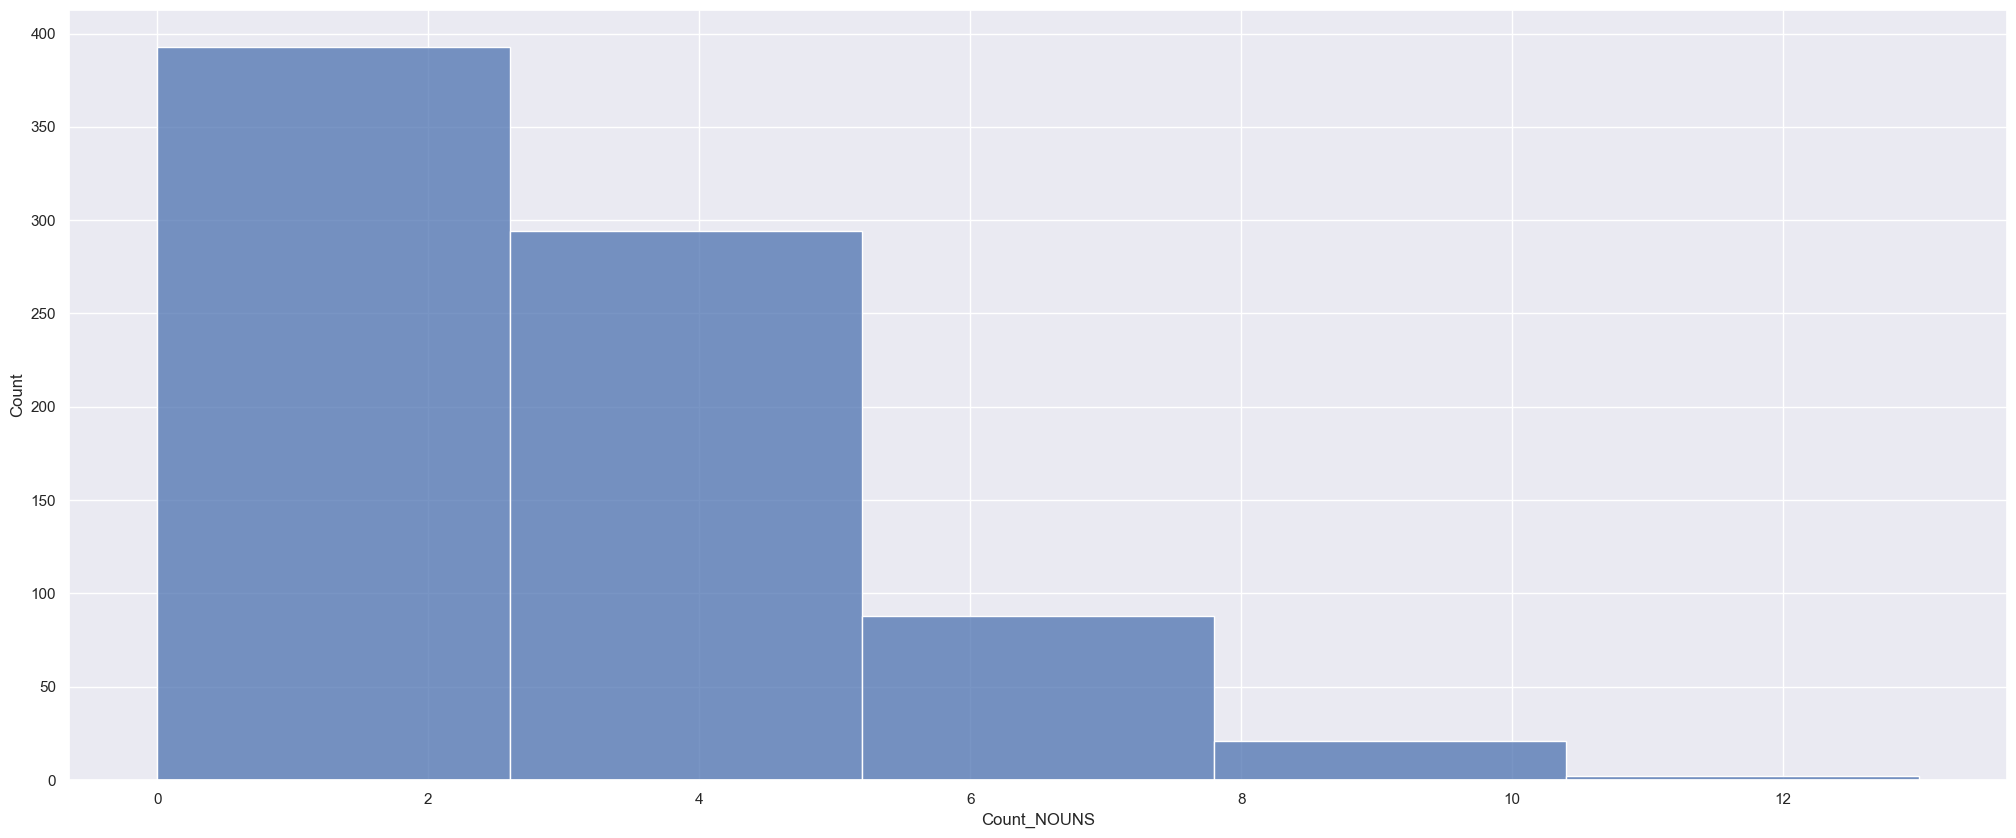

In [216]:
sns.histplot(data=df, x='Count_NOUNS', bins=5)
## So most of the nouns are in 5 or fewer
plt.savefig("Histogram of Nouns")

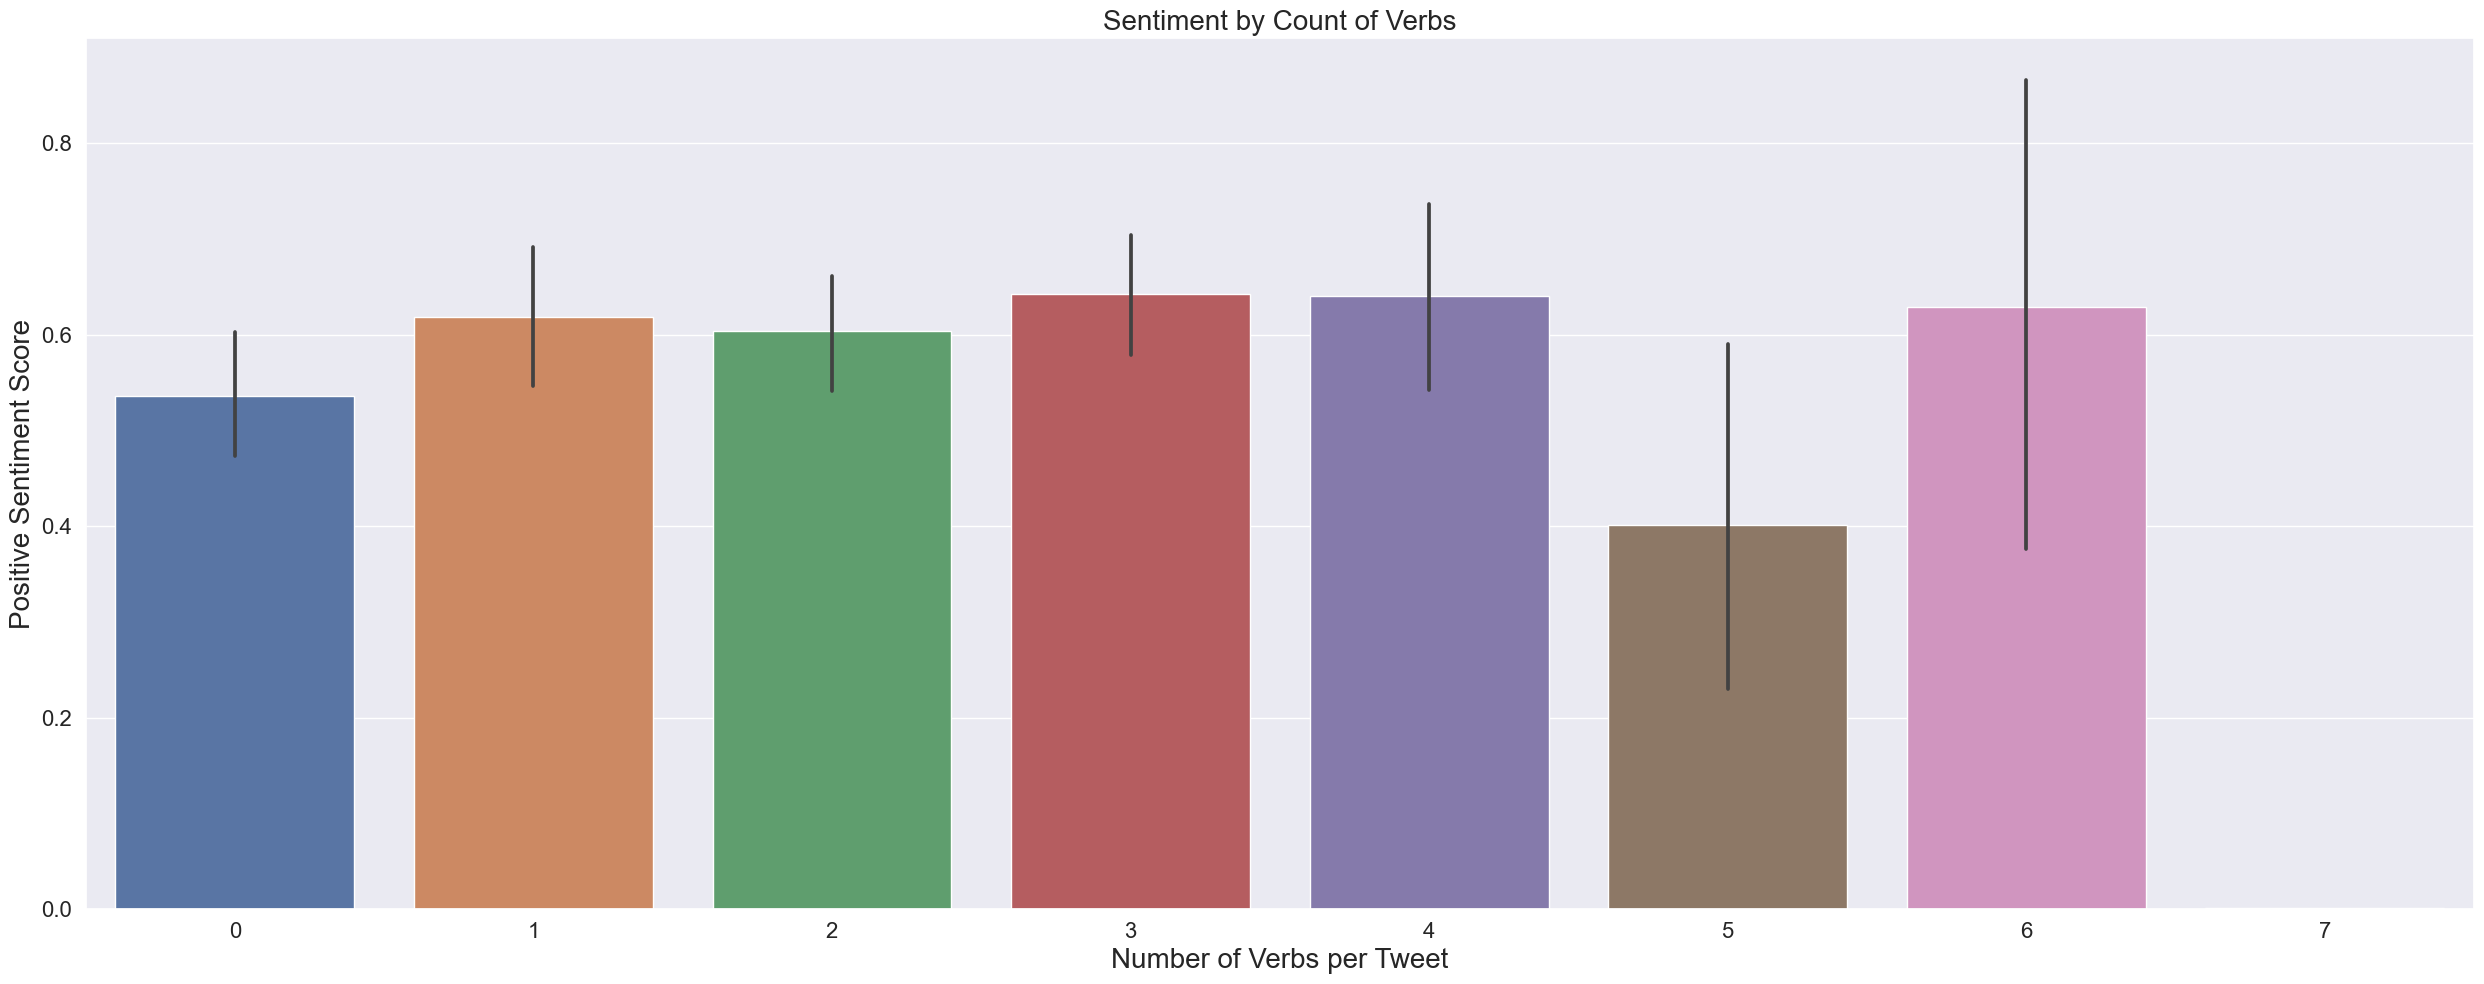

In [301]:
size = 6
sns.barplot(data=df, x="Count_VERBS", y="Positive_sentiment")
plt.xlabel('Number of Verbs per Tweet', fontsize=20)
plt.ylabel('Positive Sentiment Score', fontsize=20)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(rotation = 0, fontsize=16)
plt.title('Sentiment by Count of Verbs', fontsize=20)
plt.tight_layout()
plt.savefig('Verbs by Positive Sentiment')
plt.show()
# LESS of a clear pattern when compared to the number of nouns.

In [60]:
def count_entity(text, entity):
    """Takes a string and entity as string and returns the count of that entity"""
# Create Doc object
    doc = nlp(text)
  
  # Identify the persons
    persons = [ent.text for ent in doc.ents if ent.label_ == entity]
    count_persons = len(persons)
  # Return persons
    return count_persons

test_text = "Thirty days in the hole, under Gwen's patio, with a cool Panda Guardian named Denise"
print(count_entity(test_text, 'PERSON'))

2


In [68]:
df['Full_Tweets']= df['Full_Tweets'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tweet_Length        798 non-null    int64  
 1   Tweet_Date          798 non-null    object 
 2   UserName            798 non-null    object 
 3   Full_Tweets         798 non-null    object 
 4   Tweet_Links         798 non-null    object 
 5   at_word             544 non-null    object 
 6   Mention_Count       798 non-null    int64  
 7   Week                798 non-null    int64  
 8   Count_ADJs          798 non-null    int64  
 9   Count_NOUNS         798 non-null    int64  
 10  Count_VERBS         798 non-null    int64  
 11  Positive_sentiment  798 non-null    float64
 12  sentiment_cut       798 non-null    int64  
 13  Person_Count        798 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 87.4+ KB


In [85]:
df['Date_Count']=df['Full_Tweets'].apply(lambda x: count_entity(x, 'DATE'))

In [86]:
df.head(3)

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment,sentiment_cut,Person_Count,Product_Count,Org_Count,GPE_Count,LOC_Count,Date_Count
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1,6,2,2,4,0.000050,1,0,0,0,0,0,0
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1,6,2,1,4,0.000171,1,0,0,0,0,0,0
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1,6,1,2,4,0.971268,0,0,0,0,0,0,0


In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Tweet_Length,798.0,96.575188,48.418178,1.000000e+01,44.0000,124.000000,140.00000,144.0
Mention_Count,798.0,0.708020,0.512049,0.000000e+00,0.0000,1.000000,1.00000,3.0
Week,798.0,16.474937,18.685638,1.000000e+00,4.0000,5.000000,34.00000,52.0
Count_ADJs,798.0,0.899749,1.014314,0.000000e+00,0.0000,1.000000,1.00000,6.0
Count_NOUNS,798.0,2.754386,2.269723,0.000000e+00,1.0000,3.000000,4.00000,13.0
Count_VERBS,798.0,1.843358,1.455065,0.000000e+00,1.0000,2.000000,3.00000,7.0
Positive_sentiment,798.0,0.595527,0.440715,1.486091e-14,0.0124,0.896225,0.99986,1.0
sentiment_cut,798.0,0.500000,0.500314,0.000000e+00,0.0000,0.500000,1.00000,1.0
Person_Count,798.0,0.042607,0.208211,0.000000e+00,0.0000,0.000000,0.00000,2.0
Product_Count,798.0,0.003759,0.061237,0.000000e+00,0.0000,0.000000,0.00000,1.0


In [89]:
df.columns

Index(['Tweet_Length', 'Tweet_Date', 'UserName', 'Full_Tweets', 'Tweet_Links',
       'at_word', 'Mention_Count', 'Week', 'Count_ADJs', 'Count_NOUNS',
       'Count_VERBS', 'Positive_sentiment', 'sentiment_cut', 'Person_Count',
       'Product_Count', 'Org_Count', 'GPE_Count', 'LOC_Count', 'Date_Count'],
      dtype='object')

In [90]:
df_heat = df[['UserName', 'Mention_Count', 'Week', 'Count_ADJs', 'Count_NOUNS',
       'Count_VERBS', 'Positive_sentiment', 'sentiment_cut', 'Person_Count',
       'Product_Count', 'Org_Count', 'GPE_Count', 'LOC_Count', 'Date_Count']]

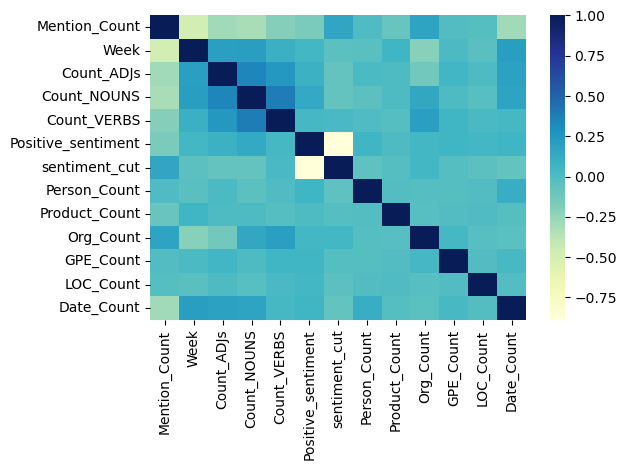

In [93]:
correlation_matrix = df_heat.corr()
_ = sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.tight_layout()
plt.savefig("Correlation of Tweet Features")

The ENT counts do not seem to add much of anything.

## 

In [236]:
df.head()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment,sentiment_cut
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1,6,2,2,4,0.000050,1
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1,6,2,1,4,0.000171,1
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1,6,1,2,4,0.971268,0
3,144,2023-02-09 05:00:15+00:00,Purina,thanks for reaching out about alpo come get...,https://t.co/VsPUdZPWfP,waffletower,1,6,2,2,4,0.975506,0
4,94,2023-02-08 20:44:37+00:00,Purina,we can t keep our tails from wagging in antic...,httpNone,OpenDoorAnimals,1,6,0,3,3,0.000001,1


In [253]:
# drawn from Kochmar's "Getting Started with NLP"
test_text= 'Thirsty dirty old yellow big chickens sit and crush their nests and smooth their milkshakes'
def tokenize(text):
    return text.split()

def vocab_size(text):
    vocab = []
    vocab += tokenize(text)
    vocab_size = len(set(vocab))
    return vocab_size

def diversity(text):
    length = 0
    length += len(tokenize(text))
    diversity = float(length)/float(vocab_size(text))
    return diversity
    

In [243]:
tokenize(test_text)

['Thirsty',
 'dirty',
 'old',
 'yellow',
 'big',
 'chickens',
 'sit',
 'and',
 'crush',
 'their',
 'nests',
 'and',
 'smooth',
 'their',
 'milkshakes']

In [244]:
vocab_size(test_text)

13

In [254]:
diversity(test_text)

1.1538461538461537

In [256]:
df['Full_Tweets']= df['Full_Tweets'].astype(str)

In [248]:
df['vocab_size'] = df['Full_Tweets'].apply(vocab_size)

In [263]:
#Interesingly, there seem to be two empty full_Tweets, so let's ditch those
empty_tweets = df[df.vocab_size == 0].index
df.drop(empty_tweets, inplace=True)

In [264]:
df.vocab_size.value_counts()

16    94
18    74
17    73
1     61
19    53
2     46
20    44
3     43
15    42
5     33
4     31
7     27
14    23
6     21
8     20
21    18
22    18
13    16
11    16
9     13
10    12
12     9
23     6
24     3
Name: vocab_size, dtype: int64

In [266]:
df['diversity'] = df['Full_Tweets'].apply(diversity)

In [267]:
df.head(5)

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment,sentiment_cut,vocab_size,diversity
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1,6,2,2,4,0.000050,1,17,1.058824
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1,6,2,1,4,0.000171,1,16,1.062500
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1,6,1,2,4,0.971268,0,17,1.176471
3,144,2023-02-09 05:00:15+00:00,Purina,thanks for reaching out about alpo come get...,https://t.co/VsPUdZPWfP,waffletower,1,6,2,2,4,0.975506,0,20,1.000000
4,94,2023-02-08 20:44:37+00:00,Purina,we can t keep our tails from wagging in antic...,httpNone,OpenDoorAnimals,1,6,0,3,3,0.000001,1,13,1.000000


In [268]:
df.to_csv('SA_df.csv', index=False)